# 2. Feature Engineering
My solution is based on a wonderfull solution, provided by Denis Larionov: https://www.kaggle.com/dlarionov/feature-engineering-xgboost

In [1]:
%reset -f
# reset magic function. Allows one to release all previously used memory. -f (force) parameter allows to run it without confirmation from the user

%run libraries_and_functions
# jupyter magic function. Run libraries_and_functions.py - load standard libraries and custom functions from the created file.

Libraries and functions loaded


## Time-Series Features
Description of basic feature engineering in time series can be found here: https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/

Modern time series predictions talk SciPy2019 https://www.youtube.com/watch?v=v5ijNXvlC5A

Time series features generation paper https://arxiv.org/pdf/1901.10200.pdf 

In [88]:
# Load the data
train = pd.read_pickle(r'output/data/train_1.pkl')
    
X = pd.read_pickle(r'output/data/X_1_EDA.pkl')
columns_to_drop = X.columns

In [3]:
# Extract year number
X['year'] = X['date_block_num'] // 12 + 2013
# Month
X['month'] = X['date_block_num'] % 12
# Map number of days in the month (no leap years here)
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
X['days'] = X['month'].map(days)
# Shift month for convenience so that January is number 1, not 0
X['month'] = X['month'] + 1
# data from Russian working calender: January 2013 to November 2015
busdays = pd.Series([17,20,20,22,18,19,23,22,21,23,20,22, 17,20,20,22,19,19,23,21,22,23,18,23, 15,19,21,22,18,21,23,21,22,22,20]) 
X['busdays'] = X['date_block_num'].map(busdays)
holidays = pd.Series([6,1,1,0,5,1,0,0,0,0,1,1, 6,1,1,0,4,2,0,0,0,0,2,1, 7,1,1,0,3,1,0,0,0,0,1]) 
X['holidays'] = X['date_block_num'].map(holidays)

In [7]:
%%time
# Let's convert our date to datetime format
train['date'] = pd.to_datetime(train.date, dayfirst = True) # Keep date only (no hours, minutes, seconds)

import datetime
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek

# Let us add how many each of the weekdays are there in the dataframe so that the sales are not zero at this day

# First group items based on date, shop_id, and date_block num
cols = ['date', 'shop_id', 'date_block_num']
group = train.groupby(cols).agg({'day_of_week': ['min']})
group.columns = ['days']
group.reset_index(inplace=True)
#display(group.head(3))

# Now we create columns for each of the weekdays
X['salesdays'] = 0; X['mo'] = 0; X['tu'] = 0; X['we'] = 0; X['th'] = 0; X['fr'] = 0; X['sa'] = 0; X['su'] = 0 

# iterate through month, shop and day to count how many each of the days are there
for month in set(group.date_block_num):
    #print('month =', month)
    for shop in set(group[group.date_block_num == month].shop_id): #iterate through shops in this month
        mo = 0; tu = 0; we = 0; th = 0; fr = 0; sa = 0; su = 0
        days = group[(group.shop_id == shop) & (group.date_block_num == month)].days
        for day in days:
            if day == 0: mo+=1
            if day == 1: tu+=1
            if day == 2: we+=1
            if day == 3: th+=1
            if day == 4: fr+=1
            if day == 5: sa+=1
            if day == 6: su+=1
        salesdays = mo+tu+we+th+fr+sa+su
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'mo'] = mo # add values to X
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'tu'] = tu
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'we'] = we
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'th'] = th        
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'fr'] = fr
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'sa'] = sa
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'su'] = su
        X.loc[(X.shop_id == shop) & (X.date_block_num == month), 'salesdays'] = salesdays
        if month == 33:
            print('shop_id = ', shop, 'salesdays = ', salesdays, mo, tu, we, th, fr, sa, su)

shop_id =  2 salesdays =  31 4 4 4 5 5 5 4
shop_id =  3 salesdays =  31 4 4 4 5 5 5 4
shop_id =  4 salesdays =  31 4 4 4 5 5 5 4
shop_id =  5 salesdays =  31 4 4 4 5 5 5 4
shop_id =  6 salesdays =  31 4 4 4 5 5 5 4
shop_id =  7 salesdays =  31 4 4 4 5 5 5 4
shop_id =  11 salesdays =  31 4 4 4 5 5 5 4
shop_id =  12 salesdays =  24 4 4 4 5 5 0 2
shop_id =  14 salesdays =  31 4 4 4 5 5 5 4
shop_id =  15 salesdays =  30 4 4 4 5 5 4 4
shop_id =  16 salesdays =  31 4 4 4 5 5 5 4
shop_id =  18 salesdays =  31 4 4 4 5 5 5 4
shop_id =  19 salesdays =  31 4 4 4 5 5 5 4
shop_id =  21 salesdays =  31 4 4 4 5 5 5 4
shop_id =  22 salesdays =  31 4 4 4 5 5 5 4
shop_id =  24 salesdays =  30 4 4 4 5 5 4 4
shop_id =  25 salesdays =  31 4 4 4 5 5 5 4
shop_id =  26 salesdays =  31 4 4 4 5 5 5 4
shop_id =  28 salesdays =  31 4 4 4 5 5 5 4
shop_id =  31 salesdays =  31 4 4 4 5 5 5 4
shop_id =  34 salesdays =  31 4 4 4 5 5 5 4
shop_id =  35 salesdays =  31 4 4 4 5 5 5 4
shop_id =  36 salesdays =  14 2 2 2 2 

Not all shops sell items all 31 days in October 2015. Internet shop # 12 shows minor or zero sales on weekends.Closed shops show zero sales. 

In [8]:
# Now let us add the data for test set manually 
X.loc[(X.date_block_num == 34), 'mo'] = 4
X.loc[(X.date_block_num == 34), 'tu'] = 4
X.loc[(X.date_block_num == 34), 'we'] = 4
X.loc[(X.date_block_num == 34), 'th'] = 4
X.loc[(X.date_block_num == 34), 'fr'] = 4
X.loc[(X.date_block_num == 34), 'sa'] = 5
X.loc[(X.date_block_num == 34), 'su'] = 5
X.loc[(X.date_block_num == 34), 'salesdays'] = 30

# With different values for shop # 12
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'mo'] = 4 
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'tu'] = 4
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'we'] = 4
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'th'] = 4        
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'fr'] = 4
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'sa'] = 0
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'su'] = 0
X.loc[(X.shop_id == 12) & (X.date_block_num == 34), 'salesdays'] = 20

In [9]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_TimeFeatures.pkl')

year  month  days  busdays  holidays  salesdays  mo  tu  we  th  fr  sa  su
0  2013      1    31       17         6         25   3   4   4   4   4   3   3
1  2013      1    31       17         6         25   3   4   4   4   4   3   3
2  2013      1    31       17         6         25   3   4   4   4   4   3   3

year  month  days  busdays  holidays  salesdays  mo  tu  we  th  fr  \
11069144  2015     11    30       20         1         30   4   4   4   4   4   
11069145  2015     11    30       20         1         30   4   4   4   4   4   
11069146  2015     11    30       20         1         30   4   4   4   4   4   

          sa  su  
11069144   5   5  
11069145   5   5  
11069146   5   5

## Shops-Items-Cats Features

In [89]:
# Load data from previous part
shops = pd.read_pickle(r'output/data/shops_1.pkl')
items = pd.read_pickle(r'output/data/items_1.pkl')
cats = pd.read_pickle(r'output/data/cats_1.pkl')

X = pd.read_pickle(r'output/data/X_1_EDA.pkl')
columns_to_drop = X.columns

#### Shops

In [12]:
# Extract city name from shops set:
shops['city'] = shops['shop_name'].str.split().map(lambda x: x[0])
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]
# Now add extracted features to X
X = pd.merge(X, shops, on=['shop_id'], how='left')
X.head(2)

date_block_num  shop_id  item_id  item_cnt_month  city_code
0               0        2       19             0.0          0
1               0        2       27             1.0          0

#### Items
Tfidf (term frequency–inverse document frequency https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is ML technique (https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html), which is often used to extract text features.   
Here it is used to extract features from item_name column of 'items' dataset. The common scheme is shown here: https://www.geeksforgeeks.org/sklearn-feature-extraction-with-tf-idf/, but instead of cosine/manhatten, etc. distances, KMean clustering is implemented here.

In [13]:
items.head(3)

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   

   item_category_id  
0                40  
1                76  
2                40

In [14]:
# Import TfidfVectorizer from sklearn to encode text data 
from sklearn.feature_extraction.text import TfidfVectorizer
# Import KMeans clustering to use it to cluster encoded data to groups
from sklearn.cluster import KMeans

In [15]:
%%time
# Now let us generate some features based on this approach: 
for min_df in (1024, 512, 256, 128, 64, 32, 16, 8, 4):
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1,10), min_df = min_df, stop_words = 'english')
    tfidf_matrix =  tf.fit_transform(items.item_name)
    feature_names = tf.get_feature_names()
    print('for min_df =', min_df,'   number of features =',len(feature_names))
    kmeans = KMeans(n_clusters=len(feature_names)+1)
    km_predicts = kmeans.fit_predict(tfidf_matrix)
    new_column_name = 'items_min_'+str(min_df)+'_nclust_'+str(len(feature_names)+1)
    items[new_column_name] = km_predicts

for min_df = 1024    number of features = 12
for min_df = 512    number of features = 29
for min_df = 256    number of features = 61
for min_df = 128    number of features = 121
for min_df = 64    number of features = 296
for min_df = 32    number of features = 785
for min_df = 16    number of features = 2028
for min_df = 8    number of features = 4940
for min_df = 4    number of features = 14154
Wall time: 35min 11s


In [16]:
# Now move the features from 'items' to 'X'
items.drop(['item_name'], axis=1, inplace=True)
X = pd.merge(X, items, on=['item_id'], how='left')
X.head(3)

date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        2       19             0.0          0   
1               0        2       27             1.0          0   
2               0        2       28             0.0          0   

   item_category_id  items_min_1024_nclust_13  items_min_512_nclust_30  \
0                40                         0                       12   
1                19                        11                       13   
2                30                        11                        8   

   items_min_256_nclust_62  items_min_128_nclust_122  items_min_64_nclust_297  \
0                       20                        19                       51   
1                       25                         5                      166   
2                       21                       113                      117   

   items_min_32_nclust_786  items_min_16_nclust_2029  items_min_8_nclust_4941  \
0                      246                       353                     3076   
1                      428                       300                      228   
2                      107                       446                     2378   

   items_min_4_nclust_14155  
0                      3669  
1                      8291  
2                      8265

#### Cats

In [17]:
cats.head()

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

In [18]:
# Extract features from 'categories' set
cats['type'] = cats['item_category_name'].str.split('-').map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

# if subtype is nan then type
cats['subtype'] = cats['item_category_name'].str.split('-').map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
#cats = cats[['item_category_id','type_code', 'subtype_code']]

In [19]:
%%time
# Now let us generate some features based on tfidf with kmeans approach: 
for min_df in range(2,6):
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1,10), min_df = min_df, stop_words = 'english')
    tfidf_matrix =  tf.fit_transform(cats.item_category_name)
    feature_names = tf.get_feature_names()
    print('for min_df =', min_df,'   number of features =',len(feature_names))
    kmeans = KMeans(n_clusters=len(feature_names)+1)
    km_predicts = kmeans.fit_predict(tfidf_matrix)
    new_column_name = 'cats_min_'+str(min_df)+'_nclust_'+str(len(feature_names)+1)
    cats[new_column_name] = km_predicts

for min_df = 2    number of features = 69


C:\Users\edyshlyu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (61) found smaller than n_clusters (70). Possibly due to duplicate points in X.
  return_n_iter=True)


for min_df = 3    number of features = 35
for min_df = 4    number of features = 19
for min_df = 5    number of features = 16
Wall time: 1.12 s


In [20]:
cats.drop(columns = ['item_category_name', 'type', 'subtype'], inplace = True)
cats.head()

item_category_id  type_code  subtype_code  cats_min_2_nclust_70  \
0                 0          0            29                    31   
1                 1          1             9                    33   
2                 2          1            10                    38   
3                 3          1            11                    21   
4                 4          1            13                    44   

   cats_min_3_nclust_36  cats_min_4_nclust_20  cats_min_5_nclust_17  
0                    26                    17                    10  
1                    32                     5                     3  
2                    16                     5                     3  
3                    28                     5                     3  
4                    18                     5                     3

In [21]:
X = pd.merge(X, cats, on=['item_category_id'], how='left')

In [22]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_ShopsItemsCatsFeatures.pkl')

city_code  item_category_id  items_min_1024_nclust_13  \
0          0                40                         0   
1          0                19                        11   
2          0                30                        11   

   items_min_512_nclust_30  items_min_256_nclust_62  items_min_128_nclust_122  \
0                       12                       20                        19   
1                       13                       25                         5   
2                        8                       21                       113   

   items_min_64_nclust_297  items_min_32_nclust_786  items_min_16_nclust_2029  \
0                       51                      246                       353   
1                      166                      428                       300   
2                      117                      107                       446   

   items_min_8_nclust_4941  items_min_4_nclust_14155  type_code  subtype_code  \
0                     3076                      3669         11             4   
1                      228                      8291          5            10   
2                     2378                      8265          8            55   

   cats_min_2_nclust_70  cats_min_3_nclust_36  cats_min_4_nclust_20  \
0                     6                     9                    12   
1                     8                    35                     0   
2                     4                    13                    10   

   cats_min_5_nclust_17  
0                     6  
1                     1  
2                    10

city_code  item_category_id  items_min_1024_nclust_13  \
11069144         19                55                         0   
11069145         19                40                         2   
11069146         19                37                         1   

          items_min_512_nclust_30  items_min_256_nclust_62  \
11069144                       12                       20   
11069145                        4                       16   
11069146                        2                       34   

          items_min_128_nclust_122  items_min_64_nclust_297  \
11069144                        19                       74   
11069145                        18                      243   
11069146                        98                      110   

          items_min_32_nclust_786  items_min_16_nclust_2029  \
11069144                      129                        47   
11069145                       76                       215   
11069146                      331                       264   

          items_min_8_nclust_4941  items_min_4_nclust_14155  type_code  \
11069144                      589                      6613         13   
11069145                      208                        31         11   
11069146                     3270                      3054         11   

          subtype_code  cats_min_2_nclust_70  cats_min_3_nclust_36  \
11069144             2                    18                     6   
11069145             4                     6                     9   
11069146             1                    13                    10   

          cats_min_4_nclust_20  cats_min_5_nclust_17  
11069144                     6                     7  
11069145                    12                     6  
11069146                    12                     6

## Target Features

#### Target Lag Features

In [3]:
X = pd.read_pickle(r'output/data/X_1_EDA.pkl')
columns_to_drop = X.columns

In [4]:
X = lag_feature(X, [1,12,24], 'item_cnt_month')

In [5]:
X = lag_feature(X, [2], 'item_cnt_month') # T for target
X['last_diff'] = X.item_cnt_month_lag_1 - X.item_cnt_month_lag_2
X.drop(columns = ['item_cnt_month_lag_2'], inplace = True)

In [6]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_TargetLagFeatures.pkl')

item_cnt_month_lag_1  item_cnt_month_lag_12  item_cnt_month_lag_24  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   

   last_diff  
0        NaN  
1        NaN  
2        NaN

item_cnt_month_lag_1  item_cnt_month_lag_12  item_cnt_month_lag_24  \
11069144                   0.0                    0.0                    2.0   
11069145                   0.0                    NaN                    NaN   
11069146                   0.0                    0.0                    NaN   

          last_diff  
11069144        0.0  
11069145        0.0  
11069146        0.0

### Target First-Last Sales Features

In [61]:
X = pd.read_pickle(r'output/data/X_1_EDA.pkl')
columns_to_drop = X.columns

first_sale_month_all_shops  last_sale_month_all_shops  \
11069142                        11.0                        1.0   
11069143                         2.0                        1.0   
11069144                        34.0                        1.0   
11069145                        11.0                        1.0   
11069146                        17.0                        1.0   

          first_sale_month  last_sale_month  max_sale_month  new_item  \
11069142              11.0              1.0            11.0         0   
11069143               NaN              NaN             NaN         1   
11069144              34.0              9.0            24.0         0   
11069145               NaN              NaN             NaN         1   
11069146              17.0             15.0            17.0         0   

          no_itemshop_sales  
11069142                  0  
11069143                  0  
11069144                  0  
11069145                  0  
11069146                  0

In [51]:
# Quick way to calcultate first sale is here. I did not find easy way like this to calculate other features calculated here.
# Months since the first sale for each shop/item pair and for item only:   
# X['first_sale_month'] = X['date_block_num'] - X.groupby(['item_id','shop_id'])['date_block_num'].transform('min')

In [ ]:
%%time
# Let us get all sales values in time for each item/shop/month. Column name is corresponding the lag month
tmp = X.copy()                                                                          #Create temporary dataframe
for i in range(34,0,-1): 
    shifted = tmp.iloc[:,0:4]                                                           # Take first 4 columns from tmp dataframe
    shifted.columns = ['date_block_num','shop_id','item_id', str(i)]                    # Column names correspond to lag
    shifted['date_block_num'] += i                                                      #change date_block_num to shifted value
    tmp = pd.merge(tmp, shifted, on=['date_block_num','shop_id','item_id'], how='left') #merge the shifted column to main df on three columns
tmp = tmp.iloc[:,4:]

downcast(tmp)

tmp_nan = tmp.replace(0, np.nan)
display(tmp.tail(10), tmp_nan.tail(10))

In [10]:
%%time
X['first_sale_month_all_shops'] = tmp.apply(lambda row: row.first_valid_index(), axis = 1)
X['last_sale_month_all_shops'] = tmp.apply(lambda row: row.last_valid_index(), axis = 1)

X['first_sale_month'] = tmp_nan.apply(lambda row: row.first_valid_index(), axis = 1)
X['last_sale_month'] = tmp_nan.apply(lambda row: row.last_valid_index(), axis = 1)

Wall time: 1h 16min 32s


In [11]:
X['max_sale_month'] = tmp_nan.idxmax(axis=1, skipna=True)

In [58]:
# Is the item new?
X['no_item_shop_sales'] = X.last_sale_month.isna().astype('int8')
# Is there any item-shop_id sales history in the previous data?
X['new_item'] = X.last_sale_month_all_shops.isna().astype('int8')

In [ ]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_FirstLastSalesFeatures.pkl')

### Target Stat Features

In [14]:
X = pd.read_pickle(r'output/data/X_1_EDA.pkl')
columns_to_drop = X.columns

In [15]:
X['nonzero_sales_freq'] = tmp_nan.count(axis = 1)/tmp.count(axis = 1)

X['target_mean'] = tmp.mean(axis = 1)
X['target_std'] = tmp.std(axis = 1)

X['target_std_to_mean'] = X['target_std']/X['target_mean']

In [16]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_TargetStatFeatures.pkl')

nonzero_sales_freq  target_mean  target_std  target_std_to_mean
0                 NaN          NaN         NaN                 NaN
1                 NaN          NaN         NaN                 NaN
2                 NaN          NaN         NaN                 NaN

nonzero_sales_freq  target_mean  target_std  target_std_to_mean
11069144            0.176471     0.205882    0.478597            2.324615
11069145            0.000000     0.000000    0.000000                 NaN
11069146            0.176471     0.294118    0.771743            2.623928

### Target EWM Features

In [17]:
X = pd.read_pickle(r'output/data/X_1_EDA.pkl')
columns_to_drop = X.columns

In [18]:
%%time
#Now let us calculate EWM features from tmp dataframe
X['EWM_mean_span2']=tmp.ewm(span=2,adjust=True, ignore_na=False, axis = 1).mean().iloc[:,-1]
X['EWM_mean_span3']=tmp.ewm(span=3,adjust=True, ignore_na=False, axis = 1).mean().iloc[:,-1]
X['EWM_mean_span6']=tmp.ewm(span=6,adjust=True, ignore_na=False, axis = 1).mean().iloc[:,-1]
X['EWM_mean_span12']=tmp.ewm(span=12,adjust=True, ignore_na=False, axis = 1).mean().iloc[:,-1]

Wall time: 4min 44s


In [19]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_TargetEWMFeatures.pkl')

EWM_mean_span2  EWM_mean_span3  EWM_mean_span6  EWM_mean_span12
0             NaN             NaN             NaN              NaN
1             NaN             NaN             NaN              NaN
2             NaN             NaN             NaN              NaN

EWM_mean_span2  EWM_mean_span3  EWM_mean_span6  EWM_mean_span12
11069144    1.354876e-04        0.002936        0.035049         0.098788
11069145    0.000000e+00        0.000000        0.000000         0.000000
11069146    2.323057e-07        0.000069        0.008371         0.062942

## Price Features

In [20]:
X = pd.read_pickle(r'output/data/X_1_EDA.pkl')
columns_to_drop = X.columns

train = pd.read_pickle(r'output/data/train_1.pkl')

### Price Variation Lag 1

In [21]:
tmp = X.iloc[:, 0:3]
# calculate mean item_price for each item
tmp = aggregate(tmp, train, ['item_id'], {'item_price': ['mean']}, ['item_avg_item_price'])
# calculate mean item_price for each item in each month
tmp = aggregate(tmp, train, ['date_block_num','item_id'], {'item_price': ['mean']}, ['date_item_avg_item_price'])
# calculate relative (to overall mean item price) price change for each item in each month
tmp['delta_price'] = (tmp['date_item_avg_item_price'] - tmp['item_avg_item_price']) / tmp['item_avg_item_price']
# calculate shifted feature
tmp = lag_feature(tmp,[1],'delta_price')
# copy to X and fill NaN with 0
X['delta_price_lag_1'] = tmp['delta_price_lag_1']#.fillna(0)

# Price aggregates per each item, month, and shop 
tmp = aggregate(tmp, train, ['date_block_num','shop_id','item_id'], {'item_price': ['mean']}, ['shop_date_item_avg_item_price'])
tmp['delta_price_shop'] = (tmp['shop_date_item_avg_item_price'] - tmp['date_item_avg_item_price']) / tmp['date_item_avg_item_price']
tmp = lag_feature(tmp,[1],'delta_price_shop')
X['delta_price_shop_lag_1'] = tmp['delta_price_shop_lag_1']

### RUB/USD Exchange Rate

In [22]:
# Due to oil prices drop/sanctions/etc Russian economy was not stable during the studied period. RUB/USD currency exchange ratio should be a help to understand situation in economy. It will also be a good corrector for prices. 
# Exchange rates are taken from: https://www.x-rates.com/average/?from=USD&to=RUB&amount=1&year=2015
usd = pd.Series([30.244074,30.179667,30.816639,31.347389,31.325703,32.309459,32.768906,32.992554,32.601117,32.077595,32.687824,32.867809,
                  33.675610,35.245171,36.195442,35.658811,34.918525,34.392044,34.684944,36.144526,37.951523,40.815324,46.257598,55.966912,
                  63.676710,64.443511,60.261687,53.179035,50.682796,54.610770,57.155767,65.355082,66.950360,63.126499,65.083095]) 
X['rub_to_usd'] = X['date_block_num'].map(usd)
#plt.plot(X.date_block_num, X.rub_to_usd); plt.show()

### Price Aggregate Statistics Lag 1

In [23]:
%%time
# Let's calculate price aggregates. We see multimodal distribution of data.

# Price aggregates per each item
X = aggregate(X, train, ['item_id'], {'item_price': ['std']}, ['std_price_per_item'])
X = aggregate(X, train, ['item_id'], {'item_price': ['mean']}, ['mean_price_per_item'])
X = aggregate(X, train, ['item_id'], {'item_price': ['min']}, ['min_price_per_item'])
X = aggregate(X, train, ['item_id'], {'item_price': ['max']}, ['max_price_per_item'])
#X = aggregate(X, train, ['item_id'], {'item_price': lambda x:x.mode()[0]}, ['mode_price_per_item'])

# Price aggregates per each item and month
X = aggregate(X, train, ['date_block_num','item_id'], {'item_price': ['std']}, ['std_price_per_item_month'])
X = aggregate(X, train, ['date_block_num','item_id'], {'item_price': ['mean']}, ['mean_price_per_item_month'])
X = aggregate(X, train, ['date_block_num','item_id'], {'item_price': ['min']}, ['min_price_per_item_month'])
X = aggregate(X, train, ['date_block_num','item_id'], {'item_price': ['max']}, ['max_price_per_item_month'])
#X = aggregate(X, train, ['date_block_num','item_id'], {'item_price': lambda x:x.mode()[0]}, ['mode_price_per_item_month'])

# Price aggregates per each item, month, and shop
X = aggregate(X, train, ['date_block_num','shop_id','item_id'], {'item_price': ['std']}, ['std_price_per_item_month_shop'])
X = aggregate(X, train, ['date_block_num','shop_id','item_id'], {'item_price': ['mean']}, ['mean_price_per_item_month_shop'])
X = aggregate(X, train, ['date_block_num','shop_id','item_id'], {'item_price': ['min']}, ['min_price_per_item_month_shop'])
X = aggregate(X, train, ['date_block_num','shop_id','item_id'], {'item_price': ['max']}, ['max_price_per_item_month_shop'])
#X = aggregate(X, train, ['date_block_num','shop_id','item_id'], {'item_price': lambda x:x.mode()[0]}, ['mode_price_per_item_month_shop'])


X = lag_feature(X, [1], 'std_price_per_item', drop = True)
X = lag_feature(X, [1], 'mean_price_per_item', drop = True)
X = lag_feature(X, [1], 'min_price_per_item', drop = True)
X = lag_feature(X, [1], 'max_price_per_item', drop = True)
#X = lag_feature(X, [1], 'mode_price_per_item', drop = True)

X = lag_feature(X, [1], 'std_price_per_item_month', drop = True)
X = lag_feature(X, [1], 'mean_price_per_item_month', drop = True)
X = lag_feature(X, [1], 'min_price_per_item_month', drop = True)
X = lag_feature(X, [1], 'max_price_per_item_month', drop = True)
#X = lag_feature(X, [1], 'mode_price_per_item_month', drop = True)

X = lag_feature(X, [1], 'std_price_per_item_month_shop', drop = True)
X = lag_feature(X, [1], 'mean_price_per_item_month_shop', drop = True)
X = lag_feature(X, [1], 'min_price_per_item_month_shop', drop = True)
X = lag_feature(X, [1], 'max_price_per_item_month_shop', drop = True)
#X = lag_feature(X, [1], 'mode_price_per_item_month_shop', drop = True)

Wall time: 2min 28s


In [24]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_PriceFeatures.pkl')

delta_price_lag_1  delta_price_shop_lag_1  rub_to_usd  \
0                NaN                     NaN   30.244074   
1                NaN                     NaN   30.244074   
2                NaN                     NaN   30.244074   

   std_price_per_item_lag_1  mean_price_per_item_lag_1  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   

   min_price_per_item_lag_1  max_price_per_item_lag_1  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   

   std_price_per_item_month_lag_1  mean_price_per_item_month_lag_1  \
0                             NaN                              NaN   
1                             NaN                              NaN   
2                             NaN                              NaN   

   min_price_per_item_month_lag_1  max_price_per_item_month_lag_1  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   

   std_price_per_item_month_shop_lag_1  mean_price_per_item_month_shop_lag_1  \
0                                  NaN                                   NaN   
1                                  NaN                                   NaN   
2                                  NaN                                   NaN   

   min_price_per_item_month_shop_lag_1  max_price_per_item_month_shop_lag_1  
0                                  NaN                                  NaN  
1                                  NaN                                  NaN  
2                                  NaN                                  NaN

delta_price_lag_1  delta_price_shop_lag_1  rub_to_usd  \
11069144           0.155905                     NaN   65.083092   
11069145          -0.091709                     NaN   65.083092   
11069146          -0.605811                     NaN   65.083092   

          std_price_per_item_lag_1  mean_price_per_item_lag_1  \
11069144                 19.826221                 198.113205   
11069145                  4.736330                  98.096298   
11069146                 96.867386                 502.297058   

          min_price_per_item_lag_1  max_price_per_item_lag_1  \
11069144                     110.0                     229.0   
11069145                      70.0                      99.0   
11069146                     198.0                     549.0   

          std_price_per_item_month_lag_1  mean_price_per_item_month_lag_1  \
11069144                        0.000000                       229.000000   
11069145                       14.000714                        89.099998   
11069146                        0.000000                       198.000000   

          min_price_per_item_month_lag_1  max_price_per_item_month_lag_1  \
11069144                      229.000000                           229.0   
11069145                       79.199997                            99.0   
11069146                      198.000000                           198.0   

          std_price_per_item_month_shop_lag_1  \
11069144                                  NaN   
11069145                                  NaN   
11069146                                  NaN   

          mean_price_per_item_month_shop_lag_1  \
11069144                                   NaN   
11069145                                   NaN   
11069146                                   NaN   

          min_price_per_item_month_shop_lag_1  \
11069144                                  NaN   
11069145                                  NaN   
11069146                                  NaN   

          max_price_per_item_month_shop_lag_1  
11069144                                  NaN  
11069145                                  NaN  
11069146                                  NaN

## Features Encodings

In [448]:
%reset -f
%run libraries_and_functions

Libraries and functions loaded


Good comparison of different encodings and regularizations: Mean (likelihood) encoding for categorical variables with high cardinality and feature interactions: a comprehensive study with Python: https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study

In [449]:
X = pd.concat([pd.read_pickle(r'output/data/X_1_EDA.pkl'),
               pd.read_pickle(r'output/data/X_TimeFeatures.pkl'),
               pd.read_pickle(r'output/data/X_ShopsItemsCatsFeatures.pkl'),
              ], axis=1)

In [450]:
columns_to_drop = X.columns

In [451]:
X.head()

date_block_num  shop_id  item_id  item_cnt_month  year  month  days  \
0               0        2       19             0.0  2013      1    31   
1               0        2       27             1.0  2013      1    31   
2               0        2       28             0.0  2013      1    31   
3               0        2       29             0.0  2013      1    31   
4               0        2       32             0.0  2013      1    31   

   busdays  holidays  salesdays  mo  tu  we  th  fr  sa  su  city_code  \
0       17         6         25   3   4   4   4   4   3   3          0   
1       17         6         25   3   4   4   4   4   3   3          0   
2       17         6         25   3   4   4   4   4   3   3          0   
3       17         6         25   3   4   4   4   4   3   3          0   
4       17         6         25   3   4   4   4   4   3   3          0   

   item_category_id  items_min_1024_nclust_13  items_min_512_nclust_30  \
0                40                         0                       12   
1                19                        11                       13   
2                30                        11                        8   
3                23                        11                        9   
4                40                         0                        1   

   items_min_256_nclust_62  items_min_128_nclust_122  items_min_64_nclust_297  \
0                       20                        19                       51   
1                       25                         5                      166   
2                       21                       113                      117   
3                       42                        32                      229   
4                        0                         6                        1   

   items_min_32_nclust_786  items_min_16_nclust_2029  items_min_8_nclust_4941  \
0                      246                       353                     3076   
1                      428                       300                      228   
2                      107                       446                     2378   
3                       20                       914                      480   
4                        1                         2                        5   

   items_min_4_nclust_14155  type_code  subtype_code  cats_min_2_nclust_70  \
0                      3669         11             4                     6   
1                      8291          5            10                     8   
2                      8265          8            55                     4   
3                     11719          5            16                    32   
4                        17         11             4                     6   

   cats_min_3_nclust_36  cats_min_4_nclust_20  cats_min_5_nclust_17  
0                     9                    12                     6  
1                    35                     0                     1  
2                    13                    10                    10  
3                    12                    11                    12  
4                     9                    12                     6

In [452]:
def alpha_smoothing(df, groupby_columns, target, new_col_name, alpha = 5):
    # calculate mean value for all
    target_mean = df[target].mean()
    # calculate group
    group =  df.groupby(groupby_columns)[target]
    # calculate mean value per each category in the group
    mean_by_category =group.transform('mean')
    # calculate number of samples per each category in the group
    n_samples_in_category = group.transform('count')
    # calculate smoothed value
    df[new_col_name]  = ((mean_by_category*n_samples_in_category) + (target_mean*alpha))/(alpha + n_samples_in_category)
    # fill NaN with global mean value
    df[new_col_name].fillna(target_mean, inplace=True)
    return df


from sklearn.model_selection import KFold
def mean_kfold_feature(df, groupby_columns, target, new_col_name, n_splits = 5, tr_test_split = 33):
    # Check that groupby_columns is list
    if not isinstance(groupby_columns, list):  
        raise Exception('groupby_columns should be of list type')
    
    df_train = df[df.date_block_num < tr_test_split]
   
    #Calculate target mean
    target_mean = df_train[target].mean()
    # Initialize new column
    df[new_col_name] = np.NaN
   
    kf = KFold(n_splits, shuffle = True, random_state=42)
    for tr_ind, val_ind in kf.split(df):
        
        # find intersection between indices. get tr_ind but only those ones that are in train data, not in test
        indices_train = pd.Series(list(set(df_train.index.to_series()) & set(tr_ind)))
        
        # If only one column is used in groupby_columns use map method
        if len(groupby_columns) == 1:
            # Caluclate mapping from intersection indices
            means_dict = df_train.iloc[indices_train].groupby(groupby_columns)[target].mean()
            # map to val indices from both train and test
            df[new_col_name].iloc[val_ind] = df[groupby_columns].iloc[val_ind].squeeze().map(means_dict)
            
        # Elif several columns are used for groupby - use merge method 
        elif len(groupby_columns) > 1:
            group = df_train.iloc[indices_train].groupby(groupby_columns)[target].mean()
            tmp = df[groupby_columns].iloc[val_ind]
            indices = tmp.index
            merged = tmp.merge(group, on = groupby_columns, how = 'left')
            merged.index = indices
            df[new_col_name].iloc[val_ind] = merged.iloc[:,-1]
        else:
            raise Exception('wrong number of columns in groupby_columns')
     
    df[new_col_name].fillna(target_mean, inplace=True)        
    return df

def kfmean_lag_feature(df, groupby_columns, new_col_name, lags, target = 'item_cnt_month', n_splits = 5, alpha = 5, tr_test_split = 33):
    if alpha ==0:
        pass
    else:
        df = alpha_smoothing(df, groupby_columns, target, new_col_name, alpha)        
    df = mean_kfold_feature(df, groupby_columns, target, new_col_name, n_splits, tr_test_split)
    df = lag_feature(df, lags, new_col_name, drop = True)
    return df

In [453]:
%%time 
# The way was done by DLarionov
X = kfmean_lag_feature(X,['date_block_num'],                               'date_avg_item_cnt',             [1])
X = kfmean_lag_feature(X,['date_block_num', 'item_id'],                    'date_item_avg_item_cnt',        [1,2,3,4,5,6])
X = kfmean_lag_feature(X,['date_block_num', 'shop_id'],                    'date_shop_avg_item_cnt',        [1,2,3,4,5,6])
X = kfmean_lag_feature(X,['date_block_num', 'item_category_id'],           'date_cat_avg_item_cnt',         [1])
X = kfmean_lag_feature(X,['date_block_num', 'shop_id', 'item_category_id'],'date_shop_cat_avg_item_cnt',    [1])
X = kfmean_lag_feature(X,['date_block_num', 'city_code'],                  'date_city_avg_item_cnt',        [1])
X = kfmean_lag_feature(X,['date_block_num', 'item_id', 'city_code'],       'date_item_city_avg_item_cnt',   [1])

C:\Users\edyshlyu\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Wall time: 15min 24s


In [4]:
%%time 
# The way was done by DLarionov
X = mean_lag_feature(X,['date_block_num'],                               'date_avg_item_cnt',             [1])
X = mean_lag_feature(X,['date_block_num', 'item_id'],                    'date_item_avg_item_cnt',        [1,2,3,4,5,6])
X = mean_lag_feature(X,['date_block_num', 'shop_id'],                    'date_shop_avg_item_cnt',        [1,2,3,4,5,6])
X = mean_lag_feature(X,['date_block_num', 'item_category_id'],           'date_cat_avg_item_cnt',         [1])
X = mean_lag_feature(X,['date_block_num', 'shop_id', 'item_category_id'],'date_shop_cat_avg_item_cnt',    [1])
X = mean_lag_feature(X,['date_block_num', 'city_code'],                  'date_city_avg_item_cnt',        [1])
X = mean_lag_feature(X,['date_block_num', 'item_id', 'city_code'],       'date_item_city_avg_item_cnt',   [1])
#X = mean_lag_feature(X,['date_block_num', 'shop_id', 'type_code'],       'date_shop_type_avg_item_cnt',   [1])
#X = mean_lag_feature(X,['date_block_num', 'shop_id', 'subtype_code'],    'date_shop_subtype_avg_item_cnt',[1])
#X = mean_lag_feature(X,['date_block_num', 'type_code'],                  'date_type_avg_item_cnt',        [1])
#X = mean_lag_feature(X,['date_block_num', 'subtype_code'],               'date_subtype_avg_item_cnt',     [1])

Wall time: 3min 23s


In [26]:
%%time
X = kfmean_lag_feature(X,['date_block_num'], 'TME_date', [1])

X = kfmean_lag_feature(X,['date_block_num', 'shop_id'],                       'TME_date_shop',        [1]) #[1,2,3,4,5,6]
X = kfmean_lag_feature(X,['date_block_num', 'item_category_id'],              'TME_date_cat',         [1])
X = kfmean_lag_feature(X,['date_block_num', 'item_id'],                       'TME_date_item',        [1]) #[1,2,3,4,5,6]
X = kfmean_lag_feature(X,['date_block_num', 'subtype_code'],                  'TME_date_subtype',     [1])
X = kfmean_lag_feature(X,['date_block_num', 'cats_min_3_nclust_36'],          'TME_date_catsmin3',    [1])
X = kfmean_lag_feature(X,['date_block_num', 'items_min_4_nclust_14155'],      'TME_date_itemsmin4',    [1])
X = kfmean_lag_feature(X,['date_block_num', 'city_code'],                     'TME_date_city',        [1])

X = kfmean_lag_feature(X,['date_block_num', 'shop_id', 'item_category_id'],   'TME_date_shop_cat',   [1])
X = kfmean_lag_feature(X,['date_block_num', 'shop_id', 'item_id'],            'TME_date_shop_item',   [1])
X = kfmean_lag_feature(X,['date_block_num', 'shop_id', 'subtype_code'],       'TME_date_shop_subtype',   [1])

X = kfmean_lag_feature(X,['date_block_num', 'item_category_id', 'item_id'],   'TME_date_cat_item',   [1])
X = kfmean_lag_feature(X,['date_block_num', 'item_category_id', 'subtype_code'],'TME_date_cat_subtype',   [1])

X = kfmean_lag_feature(X,['date_block_num', 'item_id', 'subtype_code'],       'TME_date_item_subtype',   [1])

X = kfmean_lag_feature(X,['date_block_num', 'item_id', 'city_code'],          'TME_date_item_city',   [1])

X = kfmean_lag_feature(X,['month', 'item_id'],    'TME_month_item',   [1])
X = kfmean_lag_feature(X,['month', 'shop_id'],    'TME_month_shop',   [1])
X = kfmean_lag_feature(X,['shop_id', 'subtype_code'],    'TME_shop_subtype',   [1])
X = kfmean_lag_feature(X,['item_category_id', 'item_id'],    'TME_cat_item',   [1])
X = kfmean_lag_feature(X,['item_id', 'city_code'],    'TME_item_city',   [1])

C:\Users\edyshlyu\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Wall time: 15min 54s


In [454]:
X.drop(columns = columns_to_drop, inplace = True)
downcast(X)
display(X.head(3),X.tail(3))
X.to_pickle(r'output/data/X_MeanEncodedFeatures_KF_DL.pkl')

date_avg_item_cnt_lag_1  date_item_avg_item_cnt_lag_1  \
0                      NaN                           NaN   
1                      NaN                           NaN   
2                      NaN                           NaN   

   date_item_avg_item_cnt_lag_2  date_item_avg_item_cnt_lag_3  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   

   date_item_avg_item_cnt_lag_4  date_item_avg_item_cnt_lag_5  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   

   date_item_avg_item_cnt_lag_6  date_shop_avg_item_cnt_lag_1  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   

   date_shop_avg_item_cnt_lag_2  date_shop_avg_item_cnt_lag_3  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   

   date_shop_avg_item_cnt_lag_4  date_shop_avg_item_cnt_lag_5  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   

   date_shop_avg_item_cnt_lag_6  date_cat_avg_item_cnt_lag_1  \
0                           NaN                          NaN   
1                           NaN                          NaN   
2                           NaN                          NaN   

   date_shop_cat_avg_item_cnt_lag_1  date_city_avg_item_cnt_lag_1  \
0                               NaN                           NaN   
1                               NaN                           NaN   
2                               NaN                           NaN   

   date_item_city_avg_item_cnt_lag_1  
0                                NaN  
1                                NaN  
2                                NaN

date_avg_item_cnt_lag_1  date_item_avg_item_cnt_lag_1  \
11069144                 0.299272                      0.299272   
11069145                 0.299272                      0.299272   
11069146                 0.299272                      0.299272   

          date_item_avg_item_cnt_lag_2  date_item_avg_item_cnt_lag_3  \
11069144                      0.055556                      0.085714   
11069145                      0.093750                      0.179487   
11069146                      0.133333                      0.029412   

          date_item_avg_item_cnt_lag_4  date_item_avg_item_cnt_lag_5  \
11069144                      0.121212                      0.210526   
11069145                      0.066667                      0.093750   
11069146                      0.060606                      0.057143   

          date_item_avg_item_cnt_lag_6  date_shop_avg_item_cnt_lag_1  \
11069144                      0.297297                      0.299272   
11069145                      0.108108                      0.299272   
11069146                      0.081081                      0.299272   

          date_shop_avg_item_cnt_lag_2  date_shop_avg_item_cnt_lag_3  \
11069144                      0.136185                      0.138308   
11069145                      0.125463                      0.140162   
11069146                      0.129553                      0.137133   

          date_shop_avg_item_cnt_lag_4  date_shop_avg_item_cnt_lag_5  \
11069144                      0.126882                      0.118979   
11069145                      0.135704                      0.117014   
11069146                      0.129812                      0.118608   

          date_shop_avg_item_cnt_lag_6  date_cat_avg_item_cnt_lag_1  \
11069144                      0.137923                     0.299272   
11069145                      0.137923                     0.299272   
11069146                      0.125992                     0.299272   

          date_shop_cat_avg_item_cnt_lag_1  date_city_avg_item_cnt_lag_1  \
11069144                          0.299272                      0.299272   
11069145                          0.299272                      0.299272   
11069146                          0.299272                      0.299272   

          date_item_city_avg_item_cnt_lag_1  
11069144                           0.299272  
11069145                           0.299272  
11069146                           0.299272

## Final Preparations

In [460]:
%reset -f
%run libraries_and_functions

Libraries and functions loaded


In [461]:
X = pd.concat([pd.read_pickle(r'output/data/X_1_EDA.pkl'),
               pd.read_pickle(r'output/data/X_TimeFeatures.pkl'),
               pd.read_pickle(r'output/data/X_ShopsItemsCatsFeatures.pkl'),
               pd.read_pickle(r'output/data/X_FirstLastSalesFeatures.pkl'),
               pd.read_pickle(r'output/data/X_TargetStatFeatures.pkl'),
               pd.read_pickle(r'output/data/X_TargetEWMFeatures.pkl'),
               pd.read_pickle(r'output/data/X_TargetLagFeatures.pkl'),
               pd.read_pickle(r'output/data/X_PriceFeatures.pkl'),
               pd.read_pickle(r'output/data/X_MeanEncodedFeatures_KF_DL.pkl')
              ], axis=1)

### First 6 month removal. Because of using 6 month as lag value drop first 6 months
X = X[X.date_block_num > 5]

X.to_pickle(r'output/data/X_2_FE.pkl')

display(X.head(3),X.tail(3))

date_block_num  shop_id  item_id  item_cnt_month  year  month  days  \
2262708               6        2       27             0.0  2013      7    31   
2262709               6        2       28             0.0  2013      7    31   
2262710               6        2       29             0.0  2013      7    31   

         busdays  holidays  salesdays  mo  tu  we  th  fr  sa  su  city_code  \
2262708       23         0         31   5   5   5   4   4   4   4          0   
2262709       23         0         31   5   5   5   4   4   4   4          0   
2262710       23         0         31   5   5   5   4   4   4   4          0   

         item_category_id  items_min_1024_nclust_13  items_min_512_nclust_30  \
2262708                19                        11                       13   
2262709                30                        11                        8   
2262710                23                        11                        9   

         items_min_256_nclust_62  items_min_128_nclust_122  \
2262708                       25                         5   
2262709                       21                       113   
2262710                       42                        32   

         items_min_64_nclust_297  items_min_32_nclust_786  \
2262708                      166                      428   
2262709                      117                      107   
2262710                      229                       20   

         items_min_16_nclust_2029  items_min_8_nclust_4941  \
2262708                       300                      228   
2262709                       446                     2378   
2262710                       914                      480   

         items_min_4_nclust_14155  type_code  subtype_code  \
2262708                      8291          5            10   
2262709                      8265          8            55   
2262710                     11719          5            16   

         cats_min_2_nclust_70  cats_min_3_nclust_36  cats_min_4_nclust_20  \
2262708                     8                    35                     0   
2262709                     4                    13                    10   
2262710                    32                    12                    11   

         cats_min_5_nclust_17  first_sale_month_all_shops  \
2262708                     1                         6.0   
2262709                    10                         6.0   
2262710                    12                         6.0   

         last_sale_month_all_shops  first_sale_month  last_sale_month  \
2262708                        1.0               6.0              6.0   
2262709                        1.0               NaN              NaN   
2262710                        2.0               NaN              NaN   

         max_sale_month  new_item  no_itemshop_sales  nonzero_sales_freq  \
2262708             6.0         0                  0            0.166667   
2262709             NaN         0                  1            0.000000   
2262710             NaN         0                  1            0.000000   

         target_mean  target_std  target_std_to_mean  EWM_mean_span2  \
2262708     0.166667    0.408248             2.44949        0.002747   
2262709     0.000000    0.000000                 NaN        0.000000   
2262710     0.000000    0.000000                 NaN        0.000000   

         EWM_mean_span3  EWM_mean_span6  EWM_mean_span12  \
2262708        0.015873         0.06126         0.105426   
2262709        0.000000         0.00000         0.000000   
2262710        0.000000         0.00000         0.000000   

         item_cnt_month_lag_1  item_cnt_month_lag_12  item_cnt_month_lag_24  \
2262708                   0.0                    NaN                    NaN   
2262709                   0.0                    NaN                    NaN   
2262710                   NaN                    NaN                    NaN   

         last_diff  delta_price_lag_1  delta_price_shop

date_block_num  shop_id  item_id  item_cnt_month  year  month  days  \
11069144              34       45    15757             NaN  2015     11    30   
11069145              34       45    19648             NaN  2015     11    30   
11069146              34       45      969             NaN  2015     11    30   

          busdays  holidays  salesdays  mo  tu  we  th  fr  sa  su  city_code  \
11069144       20         1         30   4   4   4   4   4   5   5         19   
11069145       20         1         30   4   4   4   4   4   5   5         19   
11069146       20         1         30   4   4   4   4   4   5   5         19   

          item_category_id  items_min_1024_nclust_13  items_min_512_nclust_30  \
11069144                55                         0                       12   
11069145                40                         2                        4   
11069146                37                         1                        2   

          items_min_256_nclust_62  items_min_128_nclust_122  \
11069144                       20                        19   
11069145                       16                        18   
11069146                       34                        98   

          items_min_64_nclust_297  items_min_32_nclust_786  \
11069144                       74                      129   
11069145                      243                       76   
11069146                      110                      331   

          items_min_16_nclust_2029  items_min_8_nclust_4941  \
11069144                        47                      589   
11069145                       215                      208   
11069146                       264                     3270   

          items_min_4_nclust_14155  type_code  subtype_code  \
11069144                      6613         13             2   
11069145                        31         11             4   
11069146                      3054         11             1   

          cats_min_2_nclust_70  cats_min_3_nclust_36  cats_min_4_nclust_20  \
11069144                    18                     6                     6   
11069145                     6                     9                    12   
11069146                    13                    10                    12   

          cats_min_5_nclust_17  first_sale_month_all_shops  \
11069144                     7                        34.0   
11069145                     6                        11.0   
11069146                     6                        17.0   

          last_sale_month_all_shops  first_sale_month  last_sale_month  \
11069144                        1.0              34.0              9.0   
11069145                        1.0               NaN              NaN   
11069146                        1.0              17.0             15.0   

          max_sale_month  new_item  no_itemshop_sales  nonzero_sales_freq  \
11069144            24.0         0                  0            0.176471   
11069145             NaN         0                  1            0.000000   
11069146            17.0         0                  0            0.176471   

          target_mean  target_std  target_std_to_mean  EWM_mean_span2  \
11069144     0.205882    0.478597            2.324615    1.354876e-04   
11069145     0.000000    0.000000                 NaN    0.000000e+00   
11069146     0.294118    0.771743            2.623928    2.323057e-07   

          EWM_mean_span3  EWM_mean_span6  EWM_mean_span12  \
11069144        0.002936        0.035049         0.098788   
11069145        0.000000        0.000000         0.000000   
11069146        0.000069        0.008371         0.062942   

          item_cnt_month_lag_1  item_cnt_month_lag_12  item_cnt_month_lag_24  \
11069144                   0.0                    0.0                    2.0   
11069145                   0.0                    NaN                    NaN   
11069146                   0.0                    0.0                    NaN   



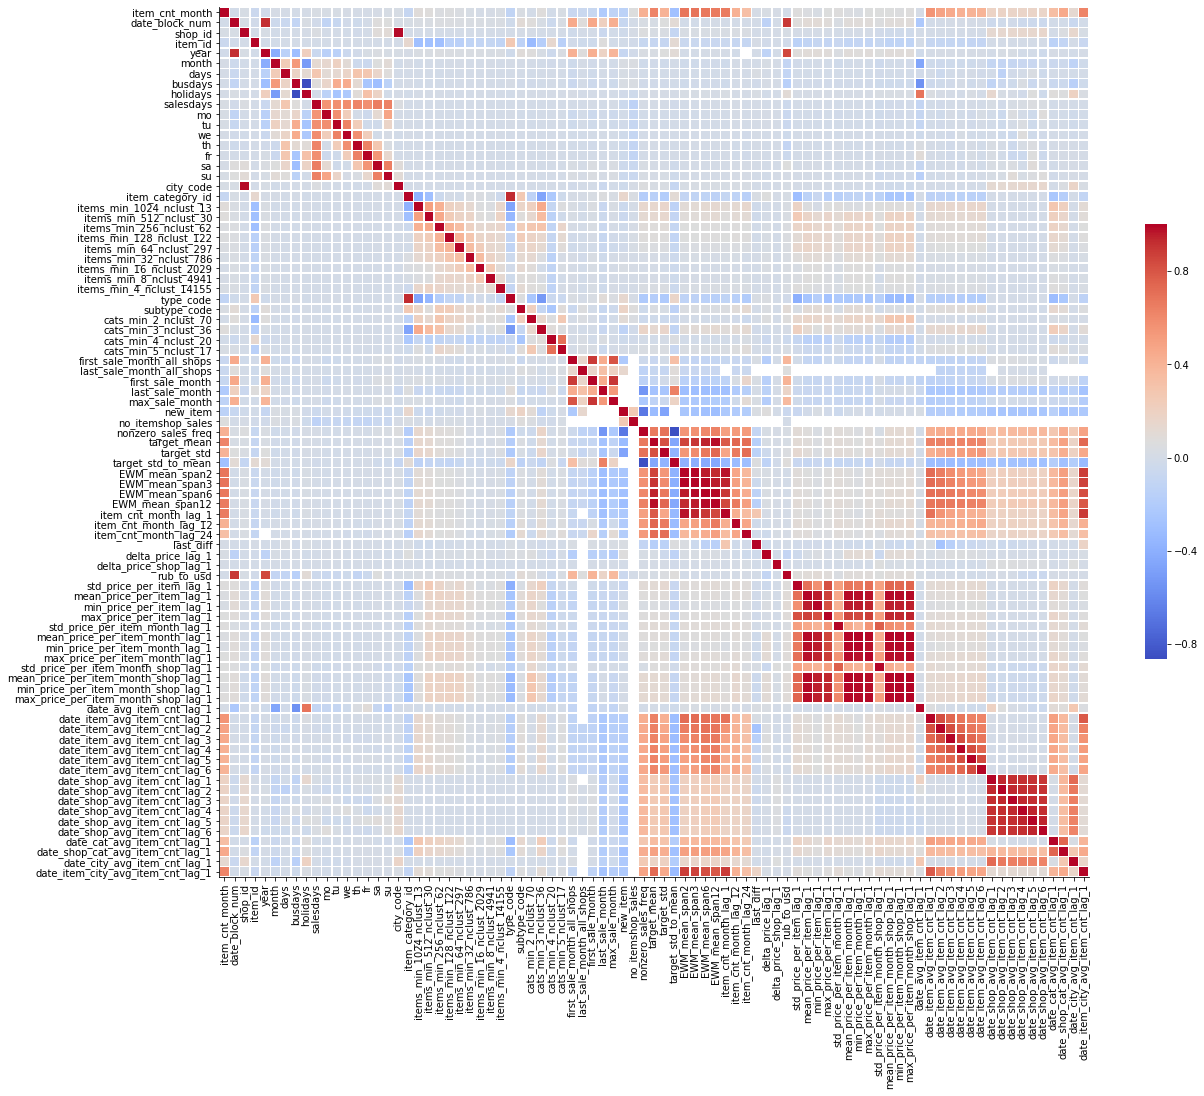

Wall time: 3min 32s


In [8]:
%%time
# Let's reorder the columns - put the target as first column
cols = ['item_cnt_month']  + [col for col in X if col != 'item_cnt_month']
X = X[cols]
# Now let's draw a correlation matrix
corr = X.corr()
g = sns.heatmap(corr,  
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False, fmt='.2f', cmap='coolwarm', xticklabels=1, yticklabels=1)
sns.despine()
g.figure.set_size_inches(20,16)
    
plt.show()

## LGBM Solution

In [462]:
%reset -f
%run libraries_and_functions

Libraries and functions loaded


In [463]:
X = pd.read_pickle(r'output/data/X_2_FE.pkl')

[500]	train's rmse: 0.768342	val's rmse: 0.785348
LGBM: RMSE train: 0.7680834651724597  RMSE val: 0.7848477776411314


C:\Users\edyshlyu\OneDrive - Imperial College London\ML\2019.10.23_Top Kagglers Course\Solution\libraries_and_functions.py:234: RuntimeWarning: invalid value encountered in true_divide
  harmonic_mean = np.round(2*split_fraction*gain_fraction/((split_fraction+gain_fraction)), 1)


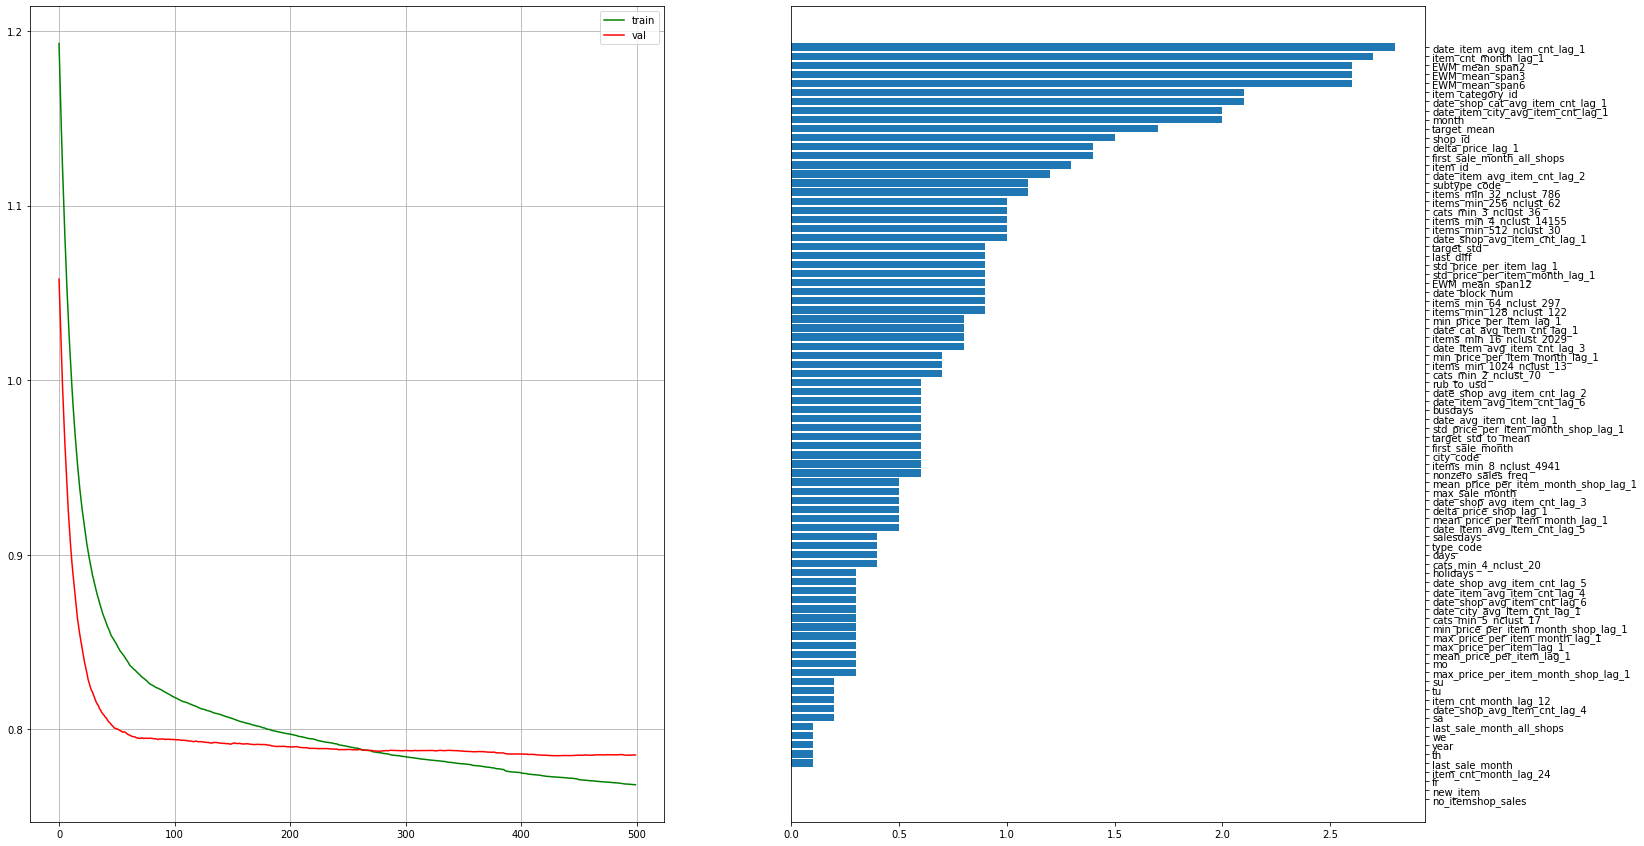

ValueError: too many values to unpack (expected 3)

In [459]:
%%time
y_pred_train, y_pred_val, y_pred_test, FI_df = LGBM(X, 'DL mean enc features 500_None_10_0.05_False', num_boost_round = 500, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05, retrain = False, plot = True)

[500]	train's rmse: 0.770936	val's rmse: 0.786034
LGBM: RMSE train: 0.7706765398462841  RMSE val: 0.7856995923030541


C:\Users\edyshlyu\OneDrive - Imperial College London\ML\2019.10.23_Top Kagglers Course\Solution\libraries_and_functions.py:234: RuntimeWarning: invalid value encountered in true_divide
  harmonic_mean = np.round(2*split_fraction*gain_fraction/((split_fraction+gain_fraction)), 1)


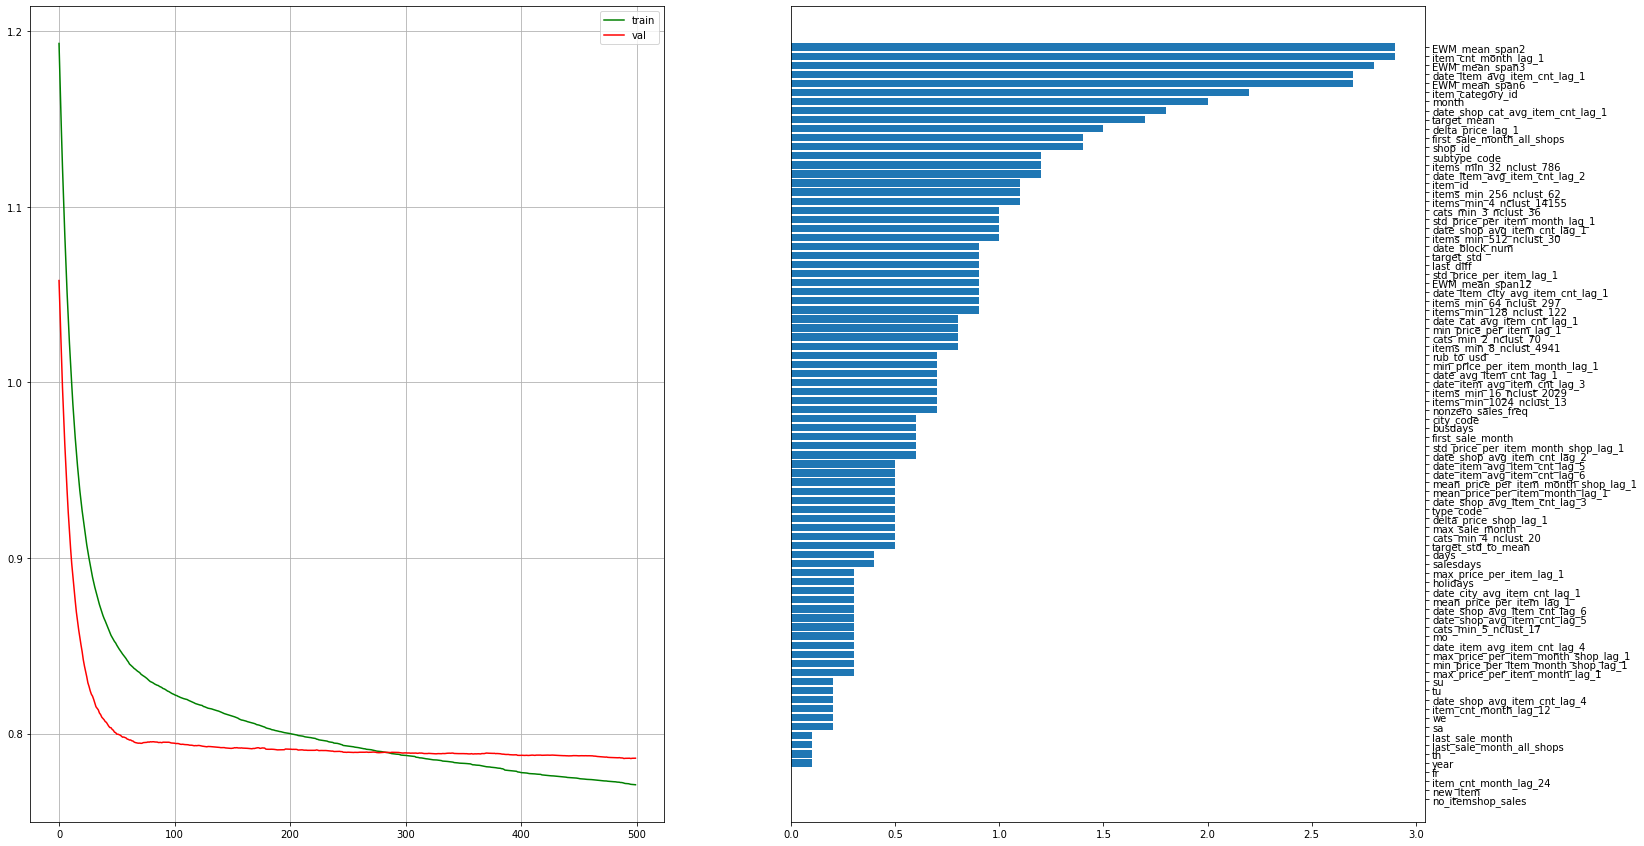

PermissionError: [Errno 13] Permission denied: 'Journal.csv'

In [464]:
%%time
y_pred_train, y_pred_val, y_pred_test, FI_df = LGBM(X, 'KF_DL mean enc features 500_None_10_0.05_False', num_boost_round = 500, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05, retrain = False, plot = True)

In [382]:
X = X[X.date_block_num > 0]
print(len(X))
X_new = X[X.new_item == 1]
print('X_new len = ',len(X_new))
print('mean target = ', X_new.item_cnt_month.mean())
X_no_itemshop_sales = X[(X.no_itemshop_sales==1) & (X.new_item==0)]
print('X_no_itemshop_sales = ', len(X_no_itemshop_sales))
print('mean target = ', X_no_itemshop_sales.item_cnt_month.mean())
X_timeseries = X[(X.no_itemshop_sales==0) & (X.new_item==0)]
print('X_timeseries = ',len(X_timeseries))
print('mean target = ', X_timeseries.item_cnt_month.mean())

assert len(X) == len(X_new)+len(X_no_itemshop_sales)+len(X_timeseries)

10703972
X_new len =  731916
mean target =  0.5471450310784879
X_no_itemshop_sales =  4910059
mean target =  0.06586778435567053
X_timeseries =  5061997
mean target =  0.48552408531707875


In [383]:
X_new_test_indices = X_new[X_new.date_block_num == 34].index
X_no_itemshop_sales_test_indices = X_no_itemshop_sales[X_no_itemshop_sales.date_block_num == 34].index
X_timeseries_test_indices = X_timeseries[X_timeseries.date_block_num == 34].index

[500]	train's rmse: 1.6658	val's rmse: 1.53598
LGBM: RMSE train: 1.6650759090939613  RMSE val: 1.5355970524673508


C:\Users\edyshlyu\OneDrive - Imperial College London\ML\2019.10.23_Top Kagglers Course\Solution\libraries_and_functions.py:234: RuntimeWarning: invalid value encountered in true_divide
  harmonic_mean = np.round(2*split_fraction*gain_fraction/((split_fraction+gain_fraction)), 1)


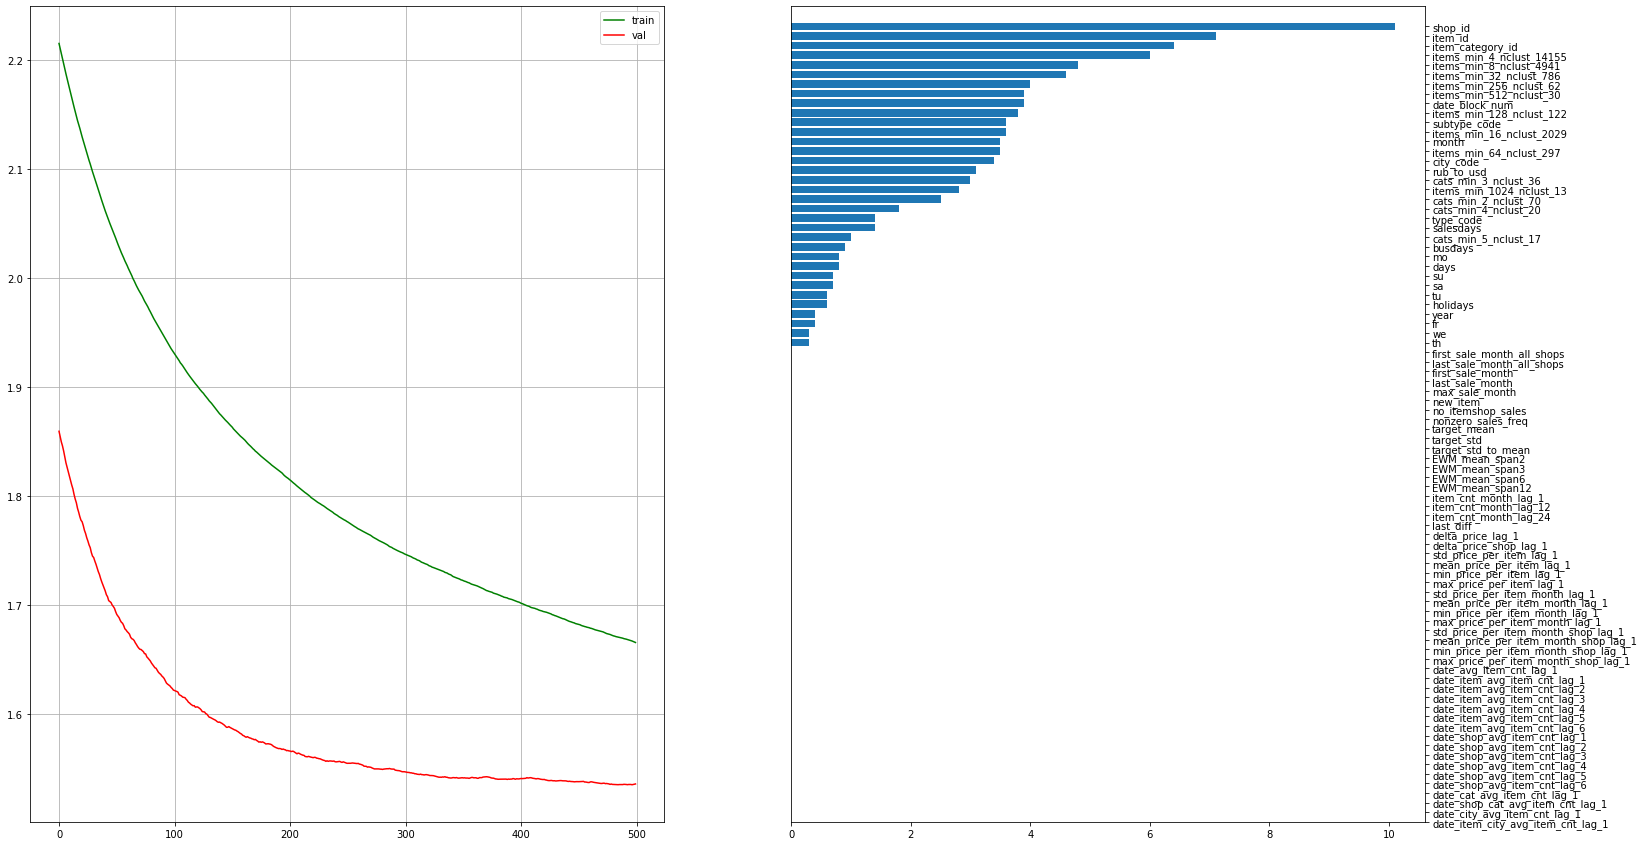

Wall time: 1min 3s


In [384]:
%%time
X_new = X_new.fillna(0)
y_pred_train, y_pred_val, y_pred_test_new, FI_df  = LGBM(X_new, 'test', num_boost_round = 500, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.01, retrain = False, plot = True)

In [385]:
FI_df=FI_df[FI_df.harmonic_mean>0]
FI_df

feature  harmonic_mean  gain  split
0                    shop_id           10.1  10.5    9.8
1                    item_id            7.1   6.4    8.0
2           item_category_id            6.4  10.6    4.6
3   items_min_4_nclust_14155            6.0   5.6    6.5
4    items_min_8_nclust_4941            4.8   3.8    6.4
5    items_min_32_nclust_786            4.6   4.6    4.6
6    items_min_256_nclust_62            4.0   4.6    3.5
7    items_min_512_nclust_30            3.9   6.1    2.9
8             date_block_num            3.9   3.1    5.3
9   items_min_128_nclust_122            3.8   4.1    3.6
10              subtype_code            3.6   3.5    3.7
11  items_min_16_nclust_2029            3.6   2.8    5.2
12                     month            3.5   3.8    3.3
13   items_min_64_nclust_297            3.5   3.3    3.8
14                 city_code            3.4   3.2    3.7
15                rub_to_usd            3.1   2.5    4.0
16      cats_min_3_nclust_36            3.0   3.6    2.6
17  items_min_1024_nclust_13            2.8   3.2    2.5
18      cats_min_2_nclust_70            2.5   2.6    2.5
19      cats_min_4_nclust_20            1.8   2.0    1.6
20                 type_code            1.4   2.0    1.1
21                 salesdays            1.4   1.4    1.4
22      cats_min_5_nclust_17            1.0   0.8    1.2
23                   busdays            0.9   0.7    1.4
24                        mo            0.8   0.9    0.8
25                      days            0.8   0.8    0.9
26                        su            0.7   0.6    0.9
27                        sa            0.7   0.8    0.6
28                        tu            0.6   0.5    0.7
29                  holidays            0.6   0.6    0.7
30                      year            0.4   0.3    0.6
31                        fr            0.4   0.4    0.5
32                        we            0.3   0.3    0.4
33                        th            0.3   0.2    0.4

In [387]:
FI_df_for_poly=FI_df[FI_df.harmonic_mean>3.6]
FI_df_other =FI_df[FI_df.harmonic_mean<=3.6]

X_new = X_new.fillna(0) # NaN not allowed in polynomial features. fillna does not influence lgbm solution results

X_for_polyfeatures = X_new[FI_df_for_poly['feature']]
X_other_features = X_new[FI_df_other['feature']]
X_other_features['item_cnt_month'] = X_new['item_cnt_month']

X_new_train = X_for_polyfeatures[X_for_polyfeatures.date_block_num < 33]#.drop(columns = 'item_cnt_month')
X_new_val = X_for_polyfeatures[X_for_polyfeatures.date_block_num > 32]#.drop(columns = 'item_cnt_month')

print(X_for_polyfeatures.shape)
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias = False)

X_train_poly = pd.DataFrame(poly.fit_transform(X_new_train), columns = poly.get_feature_names(X_new_train.columns))
X_val_poly = pd.DataFrame(poly.transform(X_new_val), columns = poly.get_feature_names(X_new_val.columns))
X_train_poly.tail(3)

X_new_poly = pd.concat([X_train_poly, X_val_poly], axis = 0)
print(X_new_poly.shape)

X_new_poly.index = X_other_features.index

X_new_poly = pd.concat([X_new_poly, X_other_features], axis = 1)
X_new_poly.shape

C:\Users\edyshlyu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(731916, 10)
(731916, 55)


(731916, 80)

In [388]:
from sklearn.metrics import mean_squared_error
def LGBM(X, Test_name = 'test', num_boost_round = 5000, early_stopping_rounds = 100, lambda_l2 = 0, learning_rate = 0.1, retrain = False, plot = False):
    
    X_train = X[X.date_block_num < 33].drop(['item_cnt_month'], axis=1)
    y_train = X[X.date_block_num < 33]['item_cnt_month']
    X_val   = X[X.date_block_num == 33].drop(['item_cnt_month'], axis=1)
    y_val   = X[X.date_block_num == 33]['item_cnt_month']
    X_test  = X[X.date_block_num == 34].drop(['item_cnt_month'], axis=1)
    
    train_dataset = lgb.Dataset(X_train, y_train)
    val_dataset = lgb.Dataset(X_val, y_val) 
#_________________________________________________________________________
    
    params = {'objective':        'regression',
              'metric':           'rmse',
              
              'num_leaves':       1417,
              'max_depth':        10,
              'min_data_in_leaf': 469,
              'max_bin':          97,
              
              'lambda_l2':        lambda_l2,
              
              'learning_rate':    learning_rate,
              'bagging_fraction': 0.5,
              'feature_fraction': 0.5,
              'bagging_freq':     1,
              'bagging_seed':     42,
              'verbosity':        -1,
              'seed':             42}
    
    evals_result = {}  # to record eval results for plotting

    model = lgb.train(params,
                      train_dataset,
                      valid_sets=[train_dataset, val_dataset],
                      valid_names=['train','val'],
                      
                      num_boost_round = num_boost_round, 
                      early_stopping_rounds=early_stopping_rounds,
                      evals_result=evals_result,                      
                      verbose_eval=500)
    
    y_pred_train = model.predict(X_train).clip(0,20) # Competition evaluation requirement: True target values are clipped into [0,20] range 
    y_pred_val = model.predict(X_val).clip(0,20)
    
    RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    RMSE_val = np.sqrt(mean_squared_error(y_val, y_pred_val)) 
   
    print(f'LGBM: RMSE train: {RMSE_train}  RMSE val: {RMSE_val}')
    
    #_____________________________________________________________________________________
    #model = model.refit(data = X_val, label = y_val, decay_rate = 0.5) #leaf_output = decay_rate * old_leaf_output + (1.0 - decay_rate) * new_leaf_output. Refit works only for CLI version
    if retrain == True:
        X_trainval = X[X.date_block_num < 34].drop(['item_cnt_month'], axis=1)
        y_trainval = X[X.date_block_num < 34]['item_cnt_month']
        trainval_dataset = lgb.Dataset(X_trainval, label=y_trainval)
        
        model = lgb.train(params,
                          trainval_dataset,
                          valid_sets=[trainval_dataset],
                          valid_names=['trainval'],
                      
                          num_boost_round = num_boost_round, 
                          early_stopping_rounds=early_stopping_rounds,
                          evals_result=evals_result,                      
                          verbose_eval=500)
        y_pred_trainval = model.predict(X_trainval).clip(0,20)
        
        RMSE_trainval = np.sqrt(mean_squared_error(y_trainval, y_pred_trainval)) 
        print(f'LGBM: RMSE train and val: {RMSE_trainval}')
    #_____________________________________________________________________________________
    if plot == True:    
        #Feature importance in LGBM can be calculated as split or gain. Here I take harmonic average of the two as a ranking for feature importance
        gain  = model.feature_importance('gain')
        gain_fraction = np.round((100 * gain / gain.sum()),1)
        split = model.feature_importance('split')
        split_fraction = np.round((100 * split / split.sum()),1)
        harmonic_mean = np.round(2*split_fraction*gain_fraction/((split_fraction+gain_fraction)), 1)
        
        FI_df = pd.DataFrame({'feature': model.feature_name(),
                              'harmonic_mean': harmonic_mean,
                              'gain': gain_fraction,
                              'split': split_fraction}).sort_values('harmonic_mean', ascending=False)
        FI_df = FI_df.reset_index(drop=True) # set the index column in order with the harmonic_mean order
        FI_df = FI_df[FI_df.harmonic_mean > 0.2]
    
        # Plotting results: Feature Importance and Train/Val Errors
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,15))
    
        ax1.plot(evals_result['train']['rmse'], 'g', label='train')
        ax1.plot(evals_result['val']['rmse'], 'r', label='val')
        ax1.legend(loc = 'upper right')
        ax1.grid(True)
    
        ax2.barh(FI_df.index, FI_df.harmonic_mean.values, tick_label = FI_df.feature)
        ax2.invert_yaxis()
        ax2.yaxis.tick_right()    
        plt.show()    
    
    
    y_pred_test = model.predict(X_test).clip(0,20)
#______________________________________________________________________________________    
    # Save the predictions to csv for submission: 
    df = pd.DataFrame(y_pred_test, columns = ['item_cnt_month']).reset_index()
    df.rename(columns = {'index':'ID'}, inplace=True)
    df.to_csv(r'output/submissions/'+Test_name+'.csv', index=False)

#_______________________________________________________________________________________
    # Save test results to Journal
    #row = '\n'+str(Test_name)+','+str(RMSE_train)+','+str(RMSE_val)
    #with open('Journal.csv','a') as file:
    #    file.write(row)
     
    return y_pred_train, y_pred_val, y_pred_test, FI_df

[500]	train's rmse: 1.63002	val's rmse: 1.53349
LGBM: RMSE train: 1.6294258010820237  RMSE val: 1.5331832586622938


C:\Users\edyshlyu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide


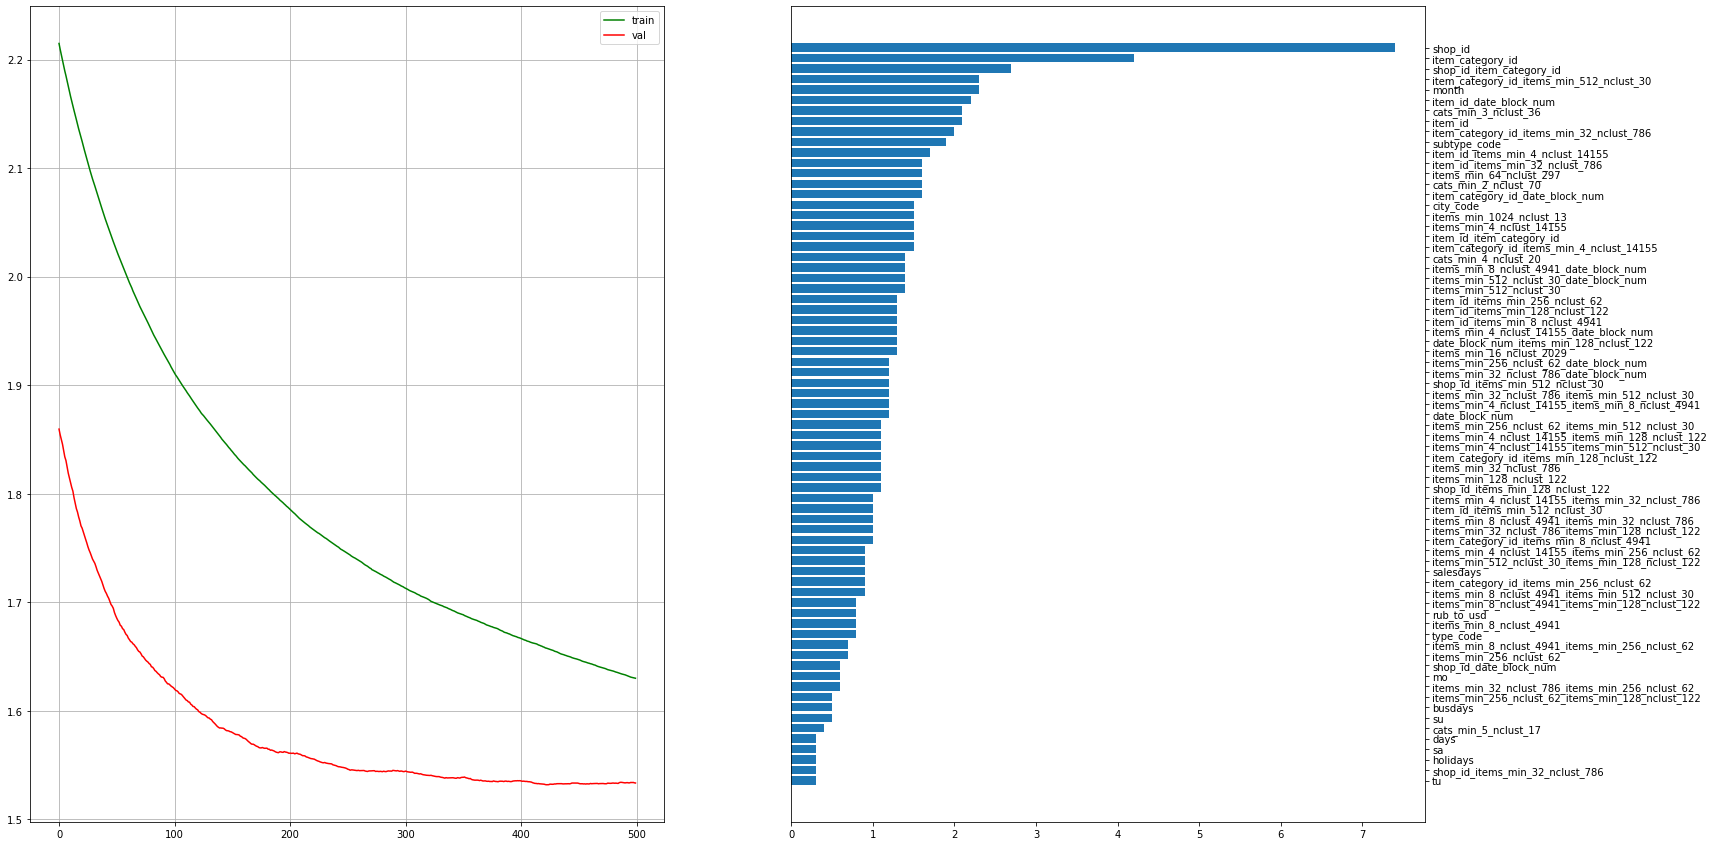

Wall time: 1min 21s


In [389]:
%%time
y_pred_train, y_pred_val, y_pred_test_new, FI_df  = LGBM(X_new_poly, 'test', num_boost_round = 500, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.01, retrain = False, plot = True)

In [390]:
FI_df

feature  harmonic_mean  gain  \
0                                             shop_id            7.4   7.6   
1                                    item_category_id            4.2   8.8   
2                            shop_id_item_category_id            2.7   2.3   
3            item_category_id_items_min_512_nclust_30            2.3   3.9   
4                                               month            2.3   3.0   
5                              item_id_date_block_num            2.2   1.8   
6                                cats_min_3_nclust_36            2.1   2.8   
7                                             item_id            2.1   1.8   
8            item_category_id_items_min_32_nclust_786            2.0   2.5   
9                                        subtype_code            1.9   1.9   
10                   item_id_items_min_4_nclust_14155            1.7   1.6   
11                    item_id_items_min_32_nclust_786            1.6   1.4   
12                            items_min_64_nclust_297            1.6   1.6   
13                               cats_min_2_nclust_70            1.6   1.9   
14                    item_category_id_date_block_num            1.6   1.3   
15                                          city_code            1.5   1.3   
16                           items_min_1024_nclust_13            1.5   1.9   
17                           items_min_4_nclust_14155            1.5   1.6   
18                           item_id_item_category_id            1.5   1.2   
19          item_category_id_items_min_4_nclust_14155            1.5   1.4   
20                               cats_min_4_nclust_20            1.4   1.9   
21             items_min_8_nclust_4941_date_block_num            1.4   1.2   
22             items_min_512_nclust_30_date_block_num            1.4   1.1   
23                            items_min_512_nclust_30            1.4   2.8   
24                    item_id_items_min_256_nclust_62            1.3   1.1   
25                   item_id_items_min_128_nclust_122            1.3   1.1   
26                    item_id_items_min_8_nclust_4941            1.3   1.1   
27            items_min_4_nclust_14155_date_block_num            1.3   1.1   
28            date_block_num_items_min_128_nclust_122            1.3   1.1   
29                           items_min_16_nclust_2029            1.3   1.0   
30             items_min_256_nclust_62_date_block_num            1.2   1.2   
31             items_min_32_nclust_786_date_block_num            1.2   0.9   
32                    shop_id_items_min_512_nclust_30            1.2   0.9   
33    items_min_32_nclust_786_items_min_512_nclust_30            1.2   1.2   
34   items_min_4_nclust_14155_items_min_8_nclust_4941            1.2   1.0   
35                                     date_block_num            1.2   1.0   
36    items_min_256_nclust_62_items_min_512_nclust_30            1.1   1.3   
37  items_min_4_nclust_14155_items_min_128_nclust_122            1.1   1.0   
38   items_min_4_nclust_14155_items_min_512_nclust_30            1.1   1.0   
39          item_category_id_items_min_128_nclust_122            1.1   1.1   
40                            items_min_32_nclust_786            1.1   1.3   
41                           items_min_128_nclust_122            1.1   1.7   
42                   shop_id_items_min_128_nclust_122            1.1   1.1   
43   items_min_4_nclust_14155_items_min_32_nclust_786            1.0   0.9   
44                    item_id_items_min_512_nclust_30            1.0   0.8   
45    items_min_8_nclust_4941_items_min_32_nclust_786            1.0   0.9   
46   items_min_32_nclust_786_items_min_128_nclust_122            1.0   1.1   
47           item_category_id_items_min_8_nclust_4941            1.0   0.8   
48   items_min_4_nclust_14155_items_min_256_nclust_62            0.9   0.9   
49   items_min_512_nclust_30_items_min_128_nclust_122            0.9   0.8   
50                                          salesdays            0.9

[500]	train's rmse: 1.6658	val's rmse: 1.53598
LGBM: RMSE train: 1.6650759090939613  RMSE val: 1.5355970524673508


C:\Users\edyshlyu\OneDrive - Imperial College London\ML\2019.10.23_Top Kagglers Course\Solution\libraries_and_functions.py:234: RuntimeWarning: invalid value encountered in true_divide
  harmonic_mean = np.round(2*split_fraction*gain_fraction/((split_fraction+gain_fraction)), 1)


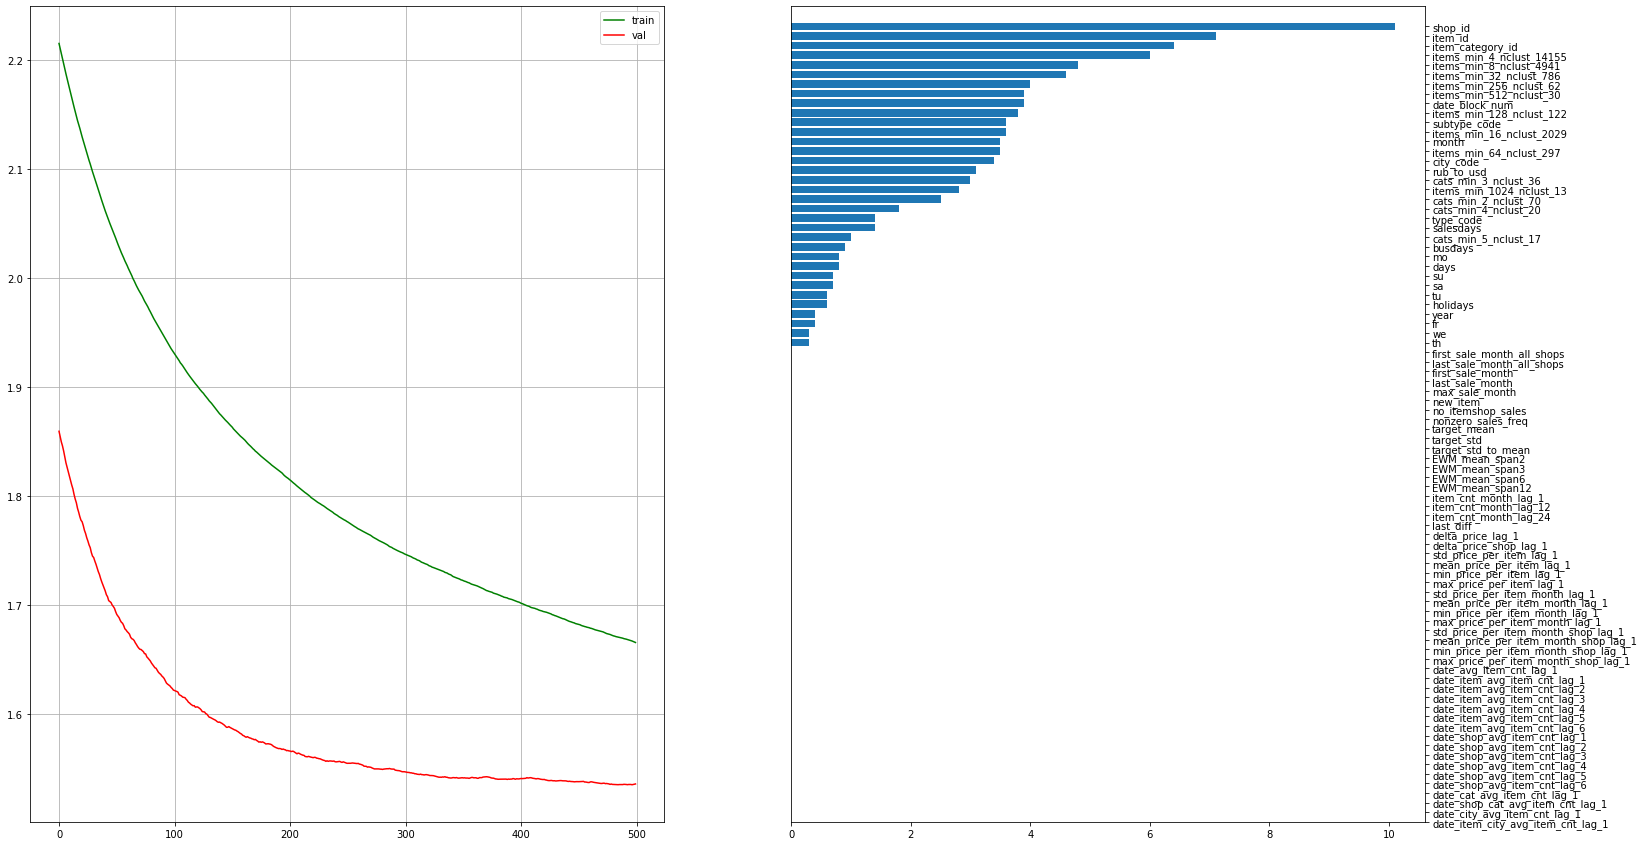

Wall time: 1min 12s


In [157]:
%%time
y_pred_train, y_pred_val, y_pred_test_new = LGBM(X_new, 'X_new_DL_mean_enc 500_None_10_0.05', num_boost_round = 500, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.01, retrain = False, plot = True)

[500]	train's rmse: 0.335083	val's rmse: 0.302221
LGBM: RMSE train: 0.33507728280842963  RMSE val: 0.3022175206355668


C:\Users\edyshlyu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide


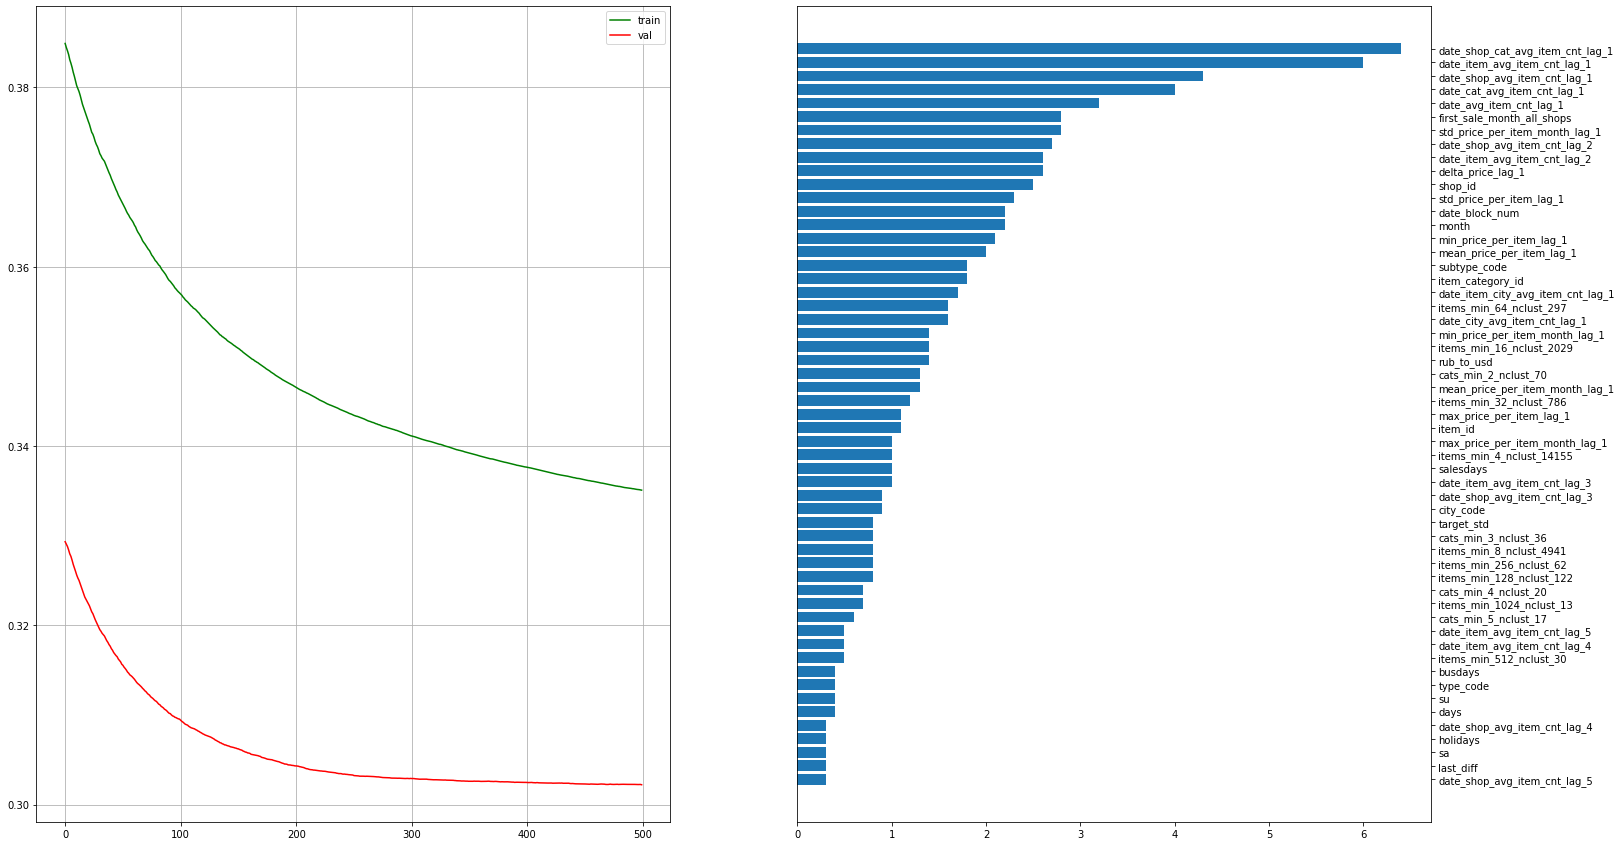

Wall time: 9min 44s


In [391]:
%%time
y_pred_train, y_pred_val, y_pred_test_no_itemshop_sales, _ = LGBM(X_no_itemshop_sales, 'test', num_boost_round = 500, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.01, retrain = False, plot = True)

[500]	train's rmse: 0.923723	val's rmse: 0.821028
LGBM: RMSE train: 0.9237155580592467  RMSE val: 0.8210283176704956


C:\Users\edyshlyu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide


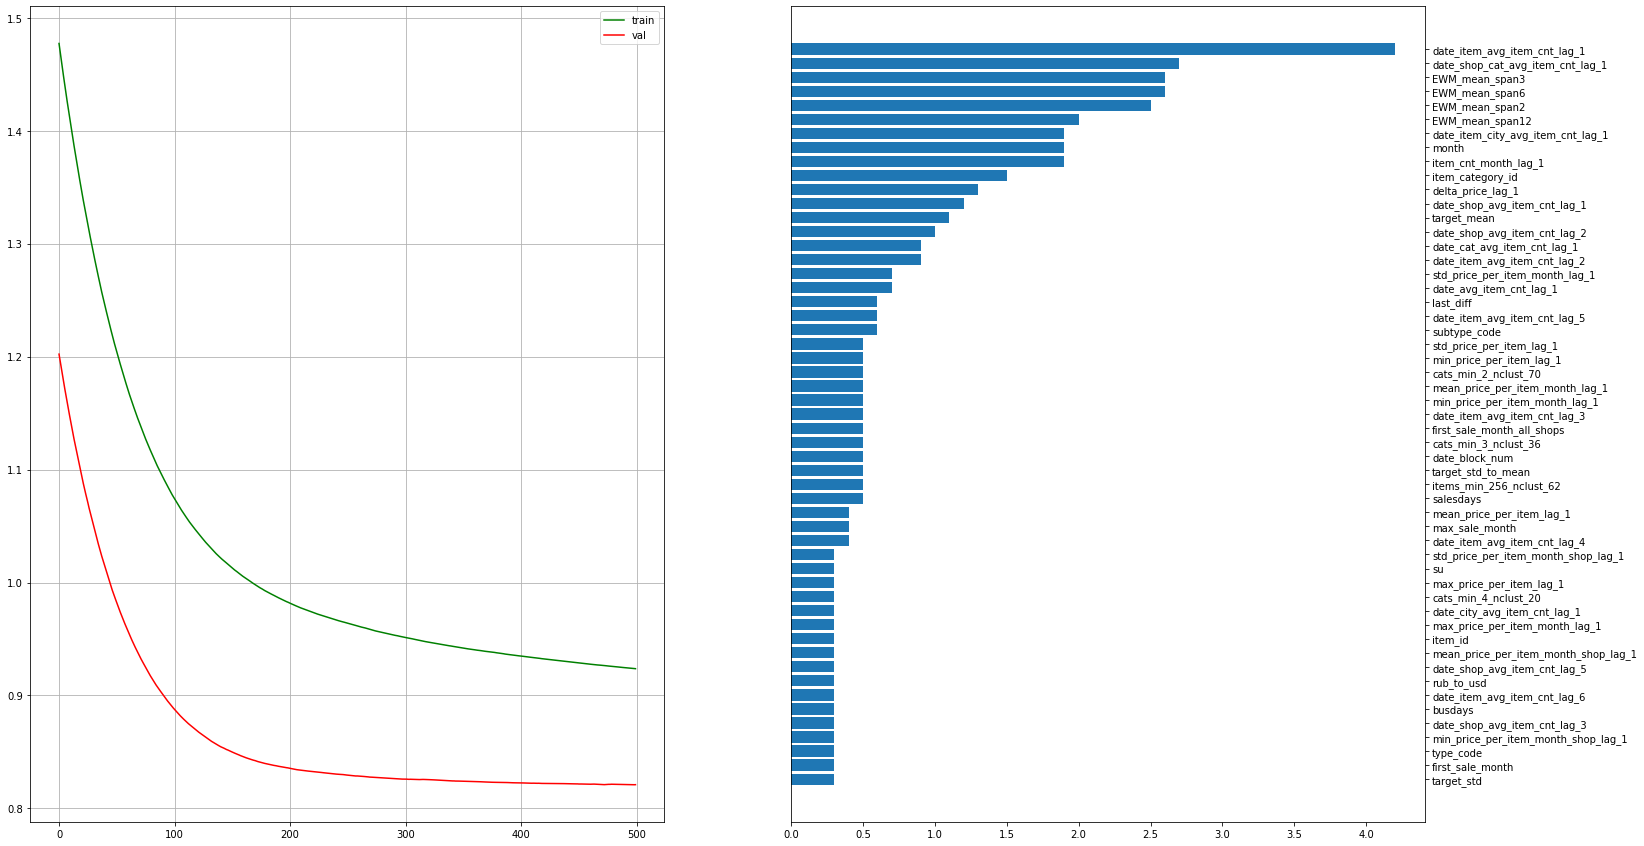

Wall time: 9min 35s


In [392]:
%%time
y_pred_train, y_pred_val, y_pred_test_timeseries, _ = LGBM(X_timeseries, 'test', num_boost_round = 500, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.01, retrain = False, plot = True)

In [393]:
preds_X_new = pd.DataFrame(data = zip(X_new_test_indices, y_pred_test_new)).set_index(0).rename(columns={1: 'item_cnt_month'}).rename_axis('ID')
preds_X_no_itemshop_sales = pd.DataFrame(data = zip(X_no_itemshop_sales_test_indices, y_pred_test_no_itemshop_sales)).set_index(0).rename(columns={1: 'item_cnt_month'}).rename_axis('ID')
preds_X_timeseries = pd.DataFrame(data = zip(X_timeseries_test_indices, y_pred_test_timeseries)).set_index(0).rename(columns={1: 'item_cnt_month'}).rename_axis('ID')

display(print(len(preds_X_new)), preds_X_new.tail(),
        print(len(preds_X_no_itemshop_sales)), preds_X_no_itemshop_sales.tail(),
        print(len(preds_X_timeseries)), preds_X_timeseries.tail())

df =  pd.concat([preds_X_new, preds_X_no_itemshop_sales, preds_X_timeseries]).sort_index()
df = df.reset_index()
df['ID'] = range(0, len(df))
df.to_csv(r'output/submissions/Split_to_3_no first month.csv', index=False)
df.tail()

16952
85819
111429


None

item_cnt_month
ID                      
11069077        0.075025
11069097        0.152959
11069101        0.145268
11069108        0.000000
11069120        0.027431

None

item_cnt_month
ID                      
11069135        0.008760
11069136        0.035890
11069141        0.041404
11069143        0.019535
11069145        0.012436

None

item_cnt_month
ID                      
11069139        0.045604
11069140        0.119675
11069142        0.113303
11069144        0.048974
11069146        0.037761

ID  item_cnt_month
214195  214195        0.113303
214196  214196        0.019535
214197  214197        0.048974
214198  214198        0.012436
214199  214199        0.037761

### Validation Scheme Selection
Let us see the training/validation error for expanding window validation sheme with a split for every month:
<img src="Figures/ExpWindowValidationScheme.png">

[200]	train's rmse: 0.806821	val's rmse: 0.707751
[200]	train's rmse: 0.804084	val's rmse: 0.774572
[200]	train's rmse: 0.801678	val's rmse: 0.86285
[200]	train's rmse: 0.802154	val's rmse: 0.798269
Wall time: 19min 19s


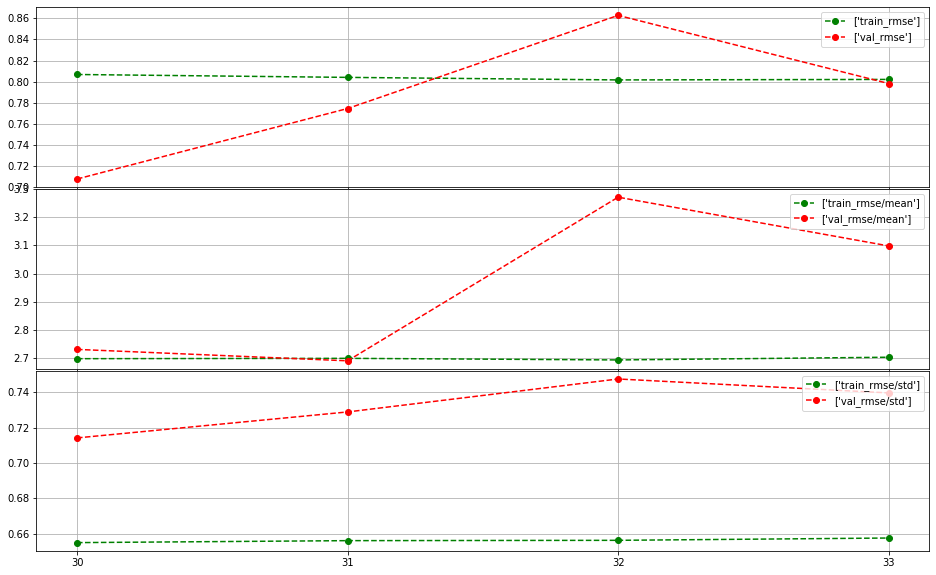

In [32]:
%%time
# My mean encodings kfold = 5, alpha = 5
error = LGBM_EXPANDING(X, min_month = 30, num_boost_round = 200, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05)

[200]	train's rmse: 0.810811	val's rmse: 0.693194
[200]	train's rmse: 0.807286	val's rmse: 0.751835
[200]	train's rmse: 0.804161	val's rmse: 0.851183
[200]	train's rmse: 0.806077	val's rmse: 0.788442
Wall time: 19min 34s


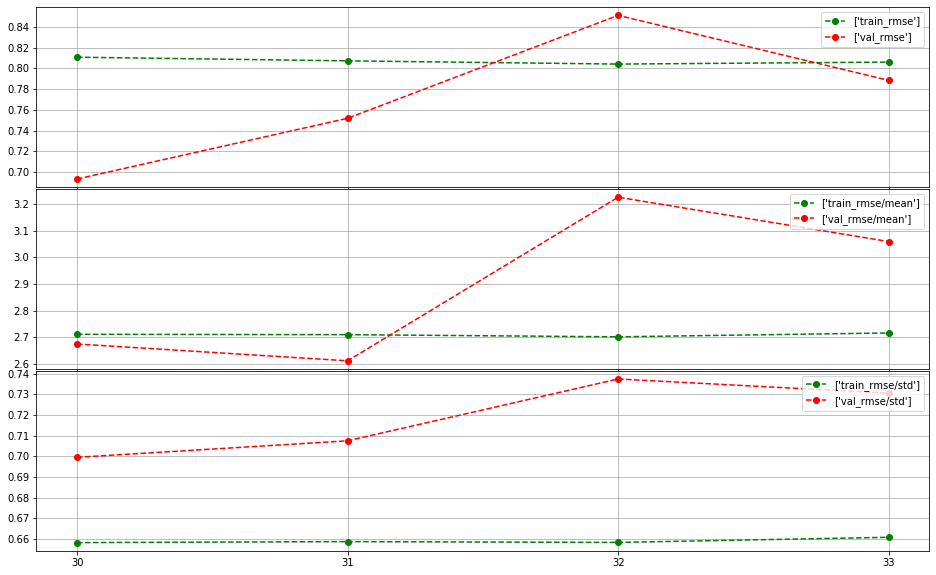

In [105]:
%%time
# My mean encodings epxanding mean reg
error = LGBM_EXPANDING(X, min_month = 30, num_boost_round = 200, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05)

[200]	train's rmse: 0.783647	val's rmse: 0.707649
[200]	train's rmse: 0.773994	val's rmse: 0.80049
[200]	train's rmse: 0.772891	val's rmse: 0.873169
[200]	train's rmse: 0.771977	val's rmse: 0.800057
[200]	train's rmse: 0.77191	val's rmse: 0.921279
[200]	train's rmse: 0.774196	val's rmse: 1.03995
[200]	train's rmse: 0.783994	val's rmse: 0.753782
[200]	train's rmse: 0.783087	val's rmse: 0.75644
[200]	train's rmse: 0.778857	val's rmse: 0.735056
[200]	train's rmse: 0.775011	val's rmse: 0.841776
[200]	train's rmse: 0.777611	val's rmse: 0.791603
[200]	train's rmse: 0.776592	val's rmse: 0.750412
[200]	train's rmse: 0.774722	val's rmse: 0.659405
[200]	train's rmse: 0.771414	val's rmse: 0.720964
[200]	train's rmse: 0.768697	val's rmse: 0.822547
[200]	train's rmse: 0.769474	val's rmse: 0.786511
Wall time: 59min 22s


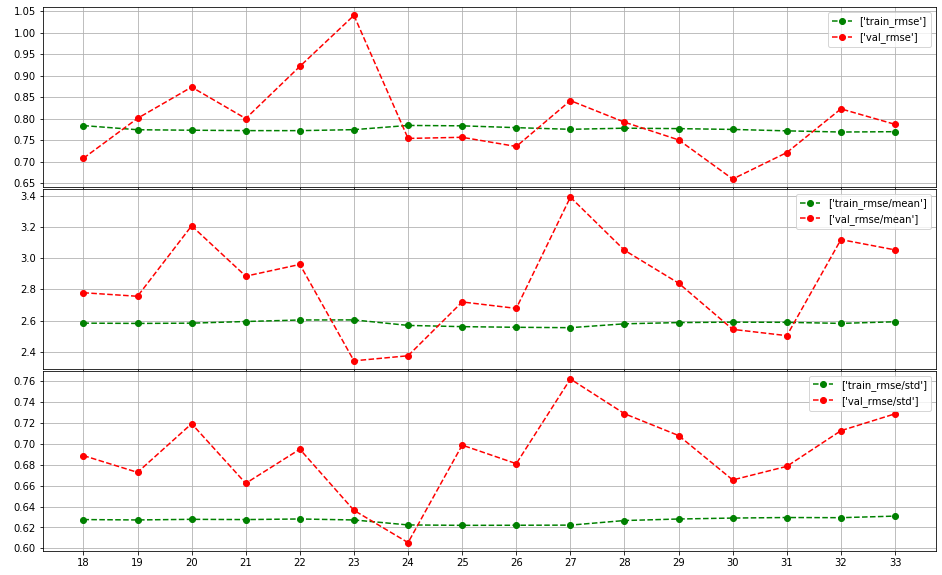

In [87]:
%%time
# My mean encodings
error = LGBM_EXPANDING(X, min_month = 18, num_boost_round = 200, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05)

[200]	train's rmse: 1.39556	val's rmse: 2.16026
[200]	train's rmse: 1.42736	val's rmse: 3.41988
[200]	train's rmse: 1.51339	val's rmse: 2.38374
[200]	train's rmse: 1.53376	val's rmse: 2.62412
[200]	train's rmse: 1.57602	val's rmse: 2.10861
[200]	train's rmse: 1.58501	val's rmse: 1.37936
[200]	train's rmse: 1.56696	val's rmse: 1.75159
[200]	train's rmse: 1.56268	val's rmse: 2.06931
[200]	train's rmse: 1.57096	val's rmse: 1.82715
[200]	train's rmse: 1.57042	val's rmse: 2.30888
[200]	train's rmse: 1.57099	val's rmse: 1.79152
[200]	train's rmse: 1.57424	val's rmse: 1.34326
[200]	train's rmse: 1.54608	val's rmse: 1.63122
[200]	train's rmse: 1.53868	val's rmse: 2.44226
[200]	train's rmse: 1.55295	val's rmse: 1.89248
[200]	train's rmse: 1.55198	val's rmse: 2.25344
[200]	train's rmse: 1.55749	val's rmse: 1.77903
[200]	train's rmse: 1.55859	val's rmse: 0.915718
[200]	train's rmse: 1.55071	val's rmse: 1.70559
[200]	train's rmse: 1.54808	val's rmse: 1.63963
[200]	train's rmse: 1.54966	val's rmse:

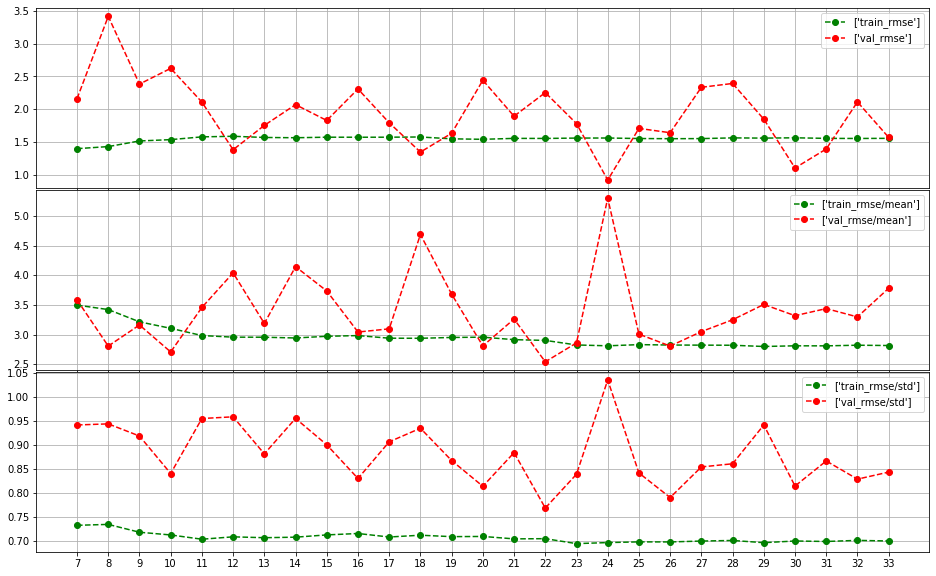

In [169]:
%%time
# X_new
error = LGBM_EXPANDING(X_new, min_month = 7, num_boost_round = 200, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05)

[200]	train's rmse: 0.374194	val's rmse: 0.305409
[200]	train's rmse: 0.365559	val's rmse: 0.300217
[200]	train's rmse: 0.357642	val's rmse: 0.329096
[200]	train's rmse: 0.354051	val's rmse: 0.328228
[200]	train's rmse: 0.350232	val's rmse: 0.486212
[200]	train's rmse: 0.358706	val's rmse: 0.299174
[200]	train's rmse: 0.352443	val's rmse: 0.325894
[200]	train's rmse: 0.34934	val's rmse: 0.407171
[200]	train's rmse: 0.34948	val's rmse: 0.334946
[200]	train's rmse: 0.347531	val's rmse: 0.287197
[200]	train's rmse: 0.344355	val's rmse: 0.274801
[200]	train's rmse: 0.341029	val's rmse: 0.298867
[200]	train's rmse: 0.33819	val's rmse: 0.308169
[200]	train's rmse: 0.337046	val's rmse: 0.268025
[200]	train's rmse: 0.334448	val's rmse: 0.350976
[200]	train's rmse: 0.333677	val's rmse: 0.311672
[200]	train's rmse: 0.33236	val's rmse: 0.501892
[200]	train's rmse: 0.338474	val's rmse: 0.305776
[200]	train's rmse: 0.336058	val's rmse: 0.33602
[200]	train's rmse: 0.335418	val's rmse: 0.249642
[200]

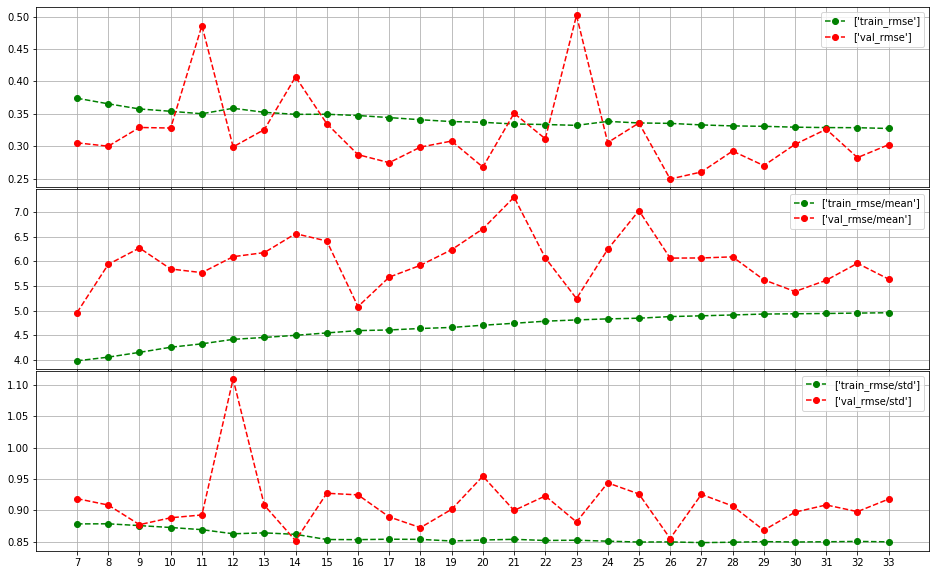

In [170]:
%%time
# X_no_itemshop_sales
error = LGBM_EXPANDING(X_no_itemshop_sales, min_month = 7, num_boost_round = 200, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05)

[200]	train's rmse: 1.0547	val's rmse: 1.0377
[200]	train's rmse: 1.0347	val's rmse: 0.936322
[200]	train's rmse: 1.00836	val's rmse: 0.954732
[200]	train's rmse: 0.988078	val's rmse: 0.986709
[200]	train's rmse: 0.972861	val's rmse: 1.42168
[200]	train's rmse: 0.997849	val's rmse: 1.1834
[200]	train's rmse: 0.988323	val's rmse: 1.01666
[200]	train's rmse: 0.981855	val's rmse: 0.972253
[200]	train's rmse: 0.971703	val's rmse: 0.863296
[200]	train's rmse: 0.956056	val's rmse: 0.798927
[200]	train's rmse: 0.945371	val's rmse: 0.849331
[200]	train's rmse: 0.934351	val's rmse: 0.850767
[200]	train's rmse: 0.926611	val's rmse: 0.935385
[200]	train's rmse: 0.924152	val's rmse: 0.856358
[200]	train's rmse: 0.918129	val's rmse: 0.890325
[200]	train's rmse: 0.911361	val's rmse: 0.883716
[200]	train's rmse: 0.908033	val's rmse: 1.31416
[200]	train's rmse: 0.921471	val's rmse: 1.03683
[200]	train's rmse: 0.921877	val's rmse: 0.914441
[200]	train's rmse: 0.919152	val's rmse: 0.806583
[200]	train's

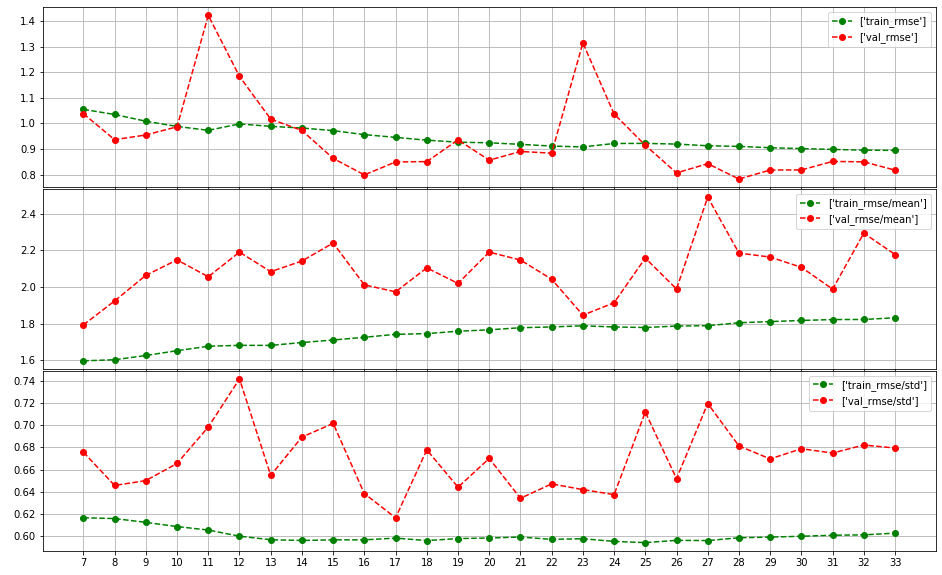

In [171]:
%%time
# X_timeseries
error = LGBM_EXPANDING(X_timeseries, min_month = 7, num_boost_round = 200, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05)

[200]	train's rmse: 0.725625	val's rmse: 0.918532
[200]	train's rmse: 0.766247	val's rmse: 1.02813
[200]	train's rmse: 0.794572	val's rmse: 0.952438
[200]	train's rmse: 0.806808	val's rmse: 0.959565
[200]	train's rmse: 0.810227	val's rmse: 1.19684
[200]	train's rmse: 0.849634	val's rmse: 0.940176
[200]	train's rmse: 0.832715	val's rmse: 0.883926
[200]	train's rmse: 0.827977	val's rmse: 0.942587
[200]	train's rmse: 0.829533	val's rmse: 0.852959
[200]	train's rmse: 0.823152	val's rmse: 0.805499
[200]	train's rmse: 0.817659	val's rmse: 0.748898
[200]	train's rmse: 0.809822	val's rmse: 0.736819
[200]	train's rmse: 0.799004	val's rmse: 0.829344
[200]	train's rmse: 0.799461	val's rmse: 0.89494
[200]	train's rmse: 0.798187	val's rmse: 0.852041
[200]	train's rmse: 0.796465	val's rmse: 0.944978
[200]	train's rmse: 0.799467	val's rmse: 1.11672
[200]	train's rmse: 0.81321	val's rmse: 0.817364
[200]	train's rmse: 0.812422	val's rmse: 0.784663
[200]	train's rmse: 0.809516	val's rmse: 0.752622
[200]

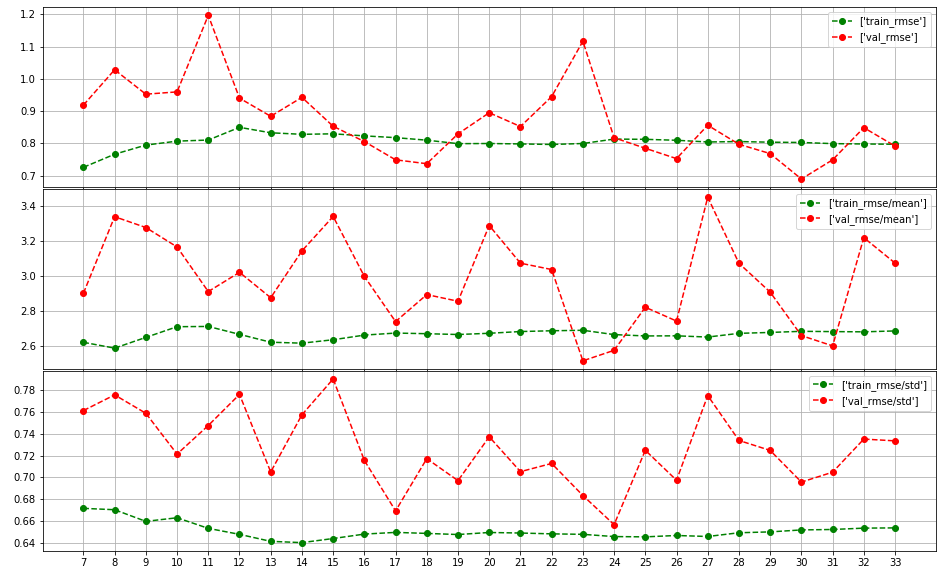

In [68]:
%%time
# DL mean encodings
error = LGBM_EXPANDING(X, min_month = 7, num_boost_round = 200, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05)

As we see, val error strongly depends on the month used for validation. Since we know that there is a variation of mean and std values for each month in the dataset (see below), it is expected that the train/val error will also deped on the month. We also plot normalized (by mean and std values) train and val rmse for comparison here. Overall there is a trend for validation error to go down as more data is used for training.
- Train error is quite stable, since adding just one month for train set in the expanding window scheme does not make much difference (except for the very first months). 
- Validation error vary depending on the month: with maximum in December and minimum during summer, which is in accordance with mean and std variation for the dataset. RMSE normalized to Std value shows the least volatile trend.
- RMSE error is used further with the training set: up to month 32, validation set month == 33 (October), test set month == 34 (November). With this, it should be expected that the train error will be lower than val error (by e.g. 0.1) and val error will be lower than test error (by another 0.1). E.g. Train error = 0.7, val error = 0.8, test error = 0.9.
- Rolling window scheme (not shown here), with window size 12 or 6 showed slightly worse results than expanding window, so expanding window validation sheme will be used further.

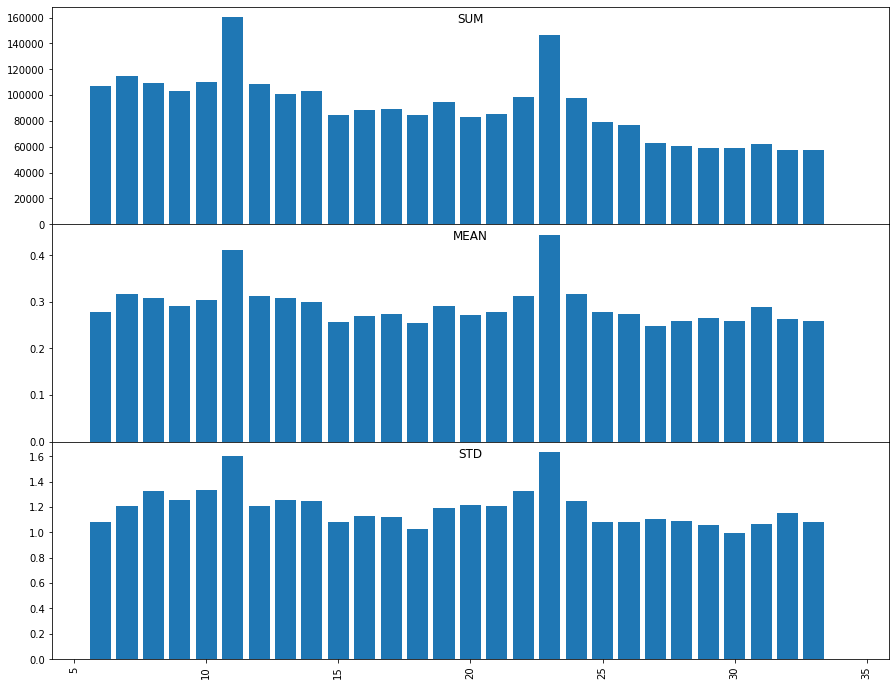

In [3]:
# Target statistics monthly variations:
groupby_and_plot(X, ['date_block_num'], 'item_cnt_month')

In [33]:
%%time
y_pred_train, y_pred_val, y_pred_test = LGBM(X, 'my mean enc features_kf5 alpha5 500_None_10_0.05_retrain for train and val_', num_boost_round = 500, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05, retrain = True, plot = False)

[500]	train's rmse: 0.773065	val's rmse: 0.792808
LGBM: RMSE train: 0.7728260730946798  RMSE val: 0.7925275565648959
[500]	trainval's rmse: 0.774487
LGBM: RMSE train and val: 0.7742565730231389
Wall time: 33min 13s


In [87]:
%%time
y_pred_train, y_pred_val, y_pred_test = LGBM(X, 'my mean enc features 500_None_10_0.05_retrain for train and val', num_boost_round = 500, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05, retrain = True, plot = False)

[500]	train's rmse: 0.75256	val's rmse: 0.796365
LGBM: RMSE train: 0.7522565759883805  RMSE val: 0.7960185598861328
[500]	trainval's rmse: 0.751163
LGBM: RMSE train and val: 0.750878410597601
Wall time: 19min 40s


[500]	train's rmse: 0.739057	val's rmse: 0.777908
LGBM: RMSE train: 0.7387364167016872  RMSE val: 0.7775766818083519


C:\Users\edyshlyu\OneDrive - Imperial College London\ML\2019.10.23_Top Kagglers Course\Solution\libraries_and_functions.py:163: RuntimeWarning: invalid value encountered in true_divide
  harmonic_mean = np.round(2*split_fraction*gain_fraction/((split_fraction+gain_fraction)), 1)


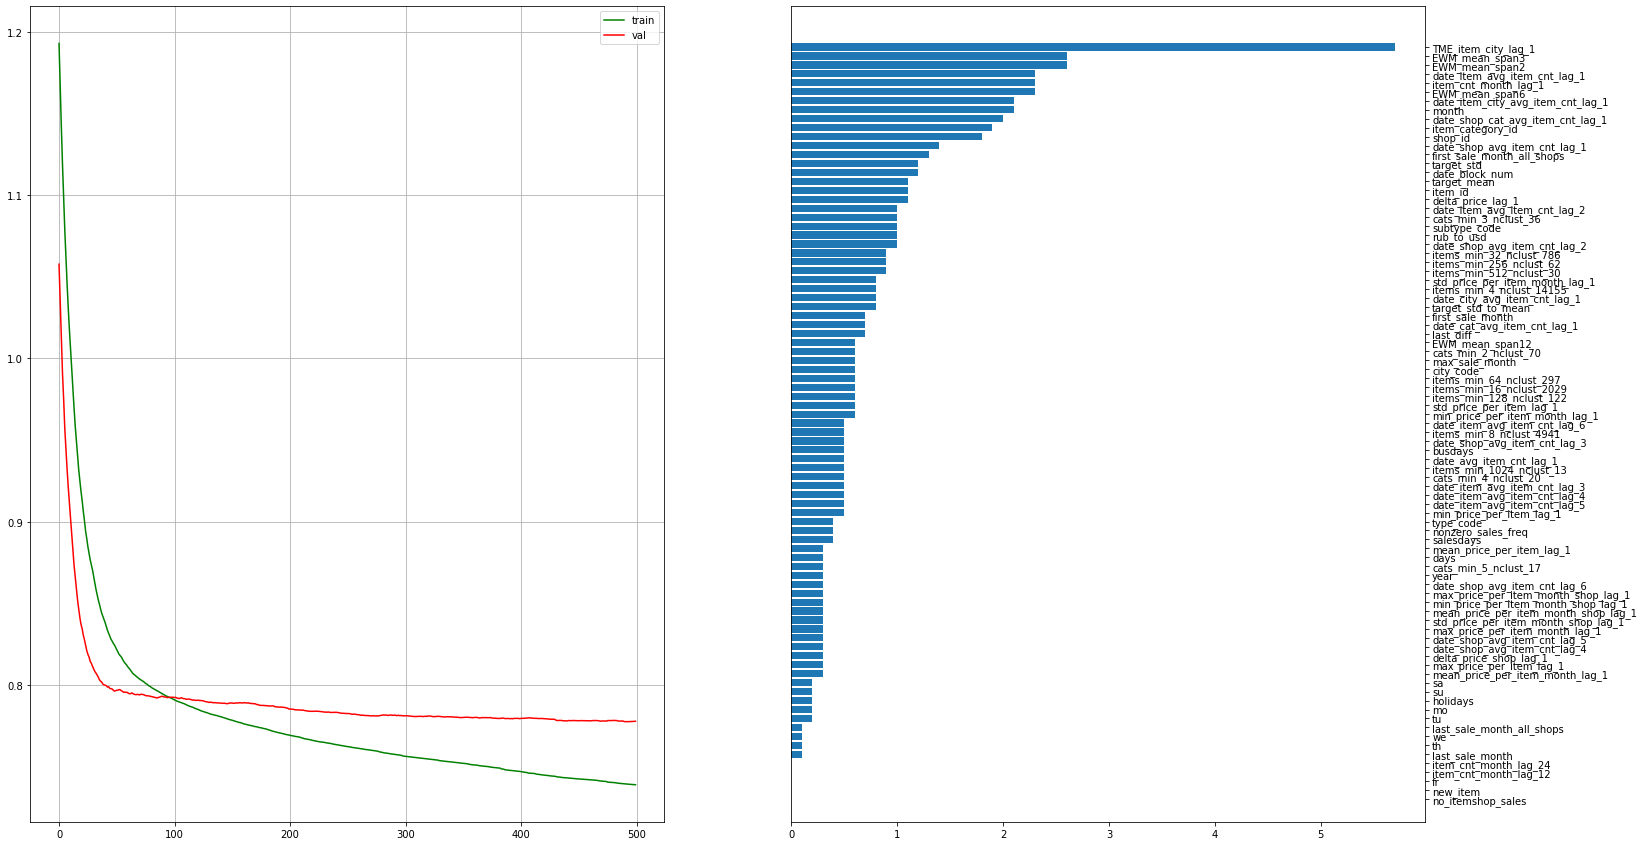

Wall time: 11min 25s


In [52]:
%%time
y_pred_train, y_pred_val, y_pred_test = LGBM(X, 'DL_mean_enc 500_None_10_0.05_True ItemCity added', num_boost_round = 500, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05, retrain = False, plot = True)

[500]	train's rmse: 0.764765	val's rmse: 0.77982
LGBM: RMSE train: 0.7645011226397512  RMSE val: 0.7795466540167706


C:\Users\edyshlyu\OneDrive - Imperial College London\ML\2019.10.23_Top Kagglers Course\Solution\libraries_and_functions.py:145: RuntimeWarning: invalid value encountered in true_divide
  harmonic_mean = np.round(2*split_fraction*gain_fraction/((split_fraction+gain_fraction)), 1)


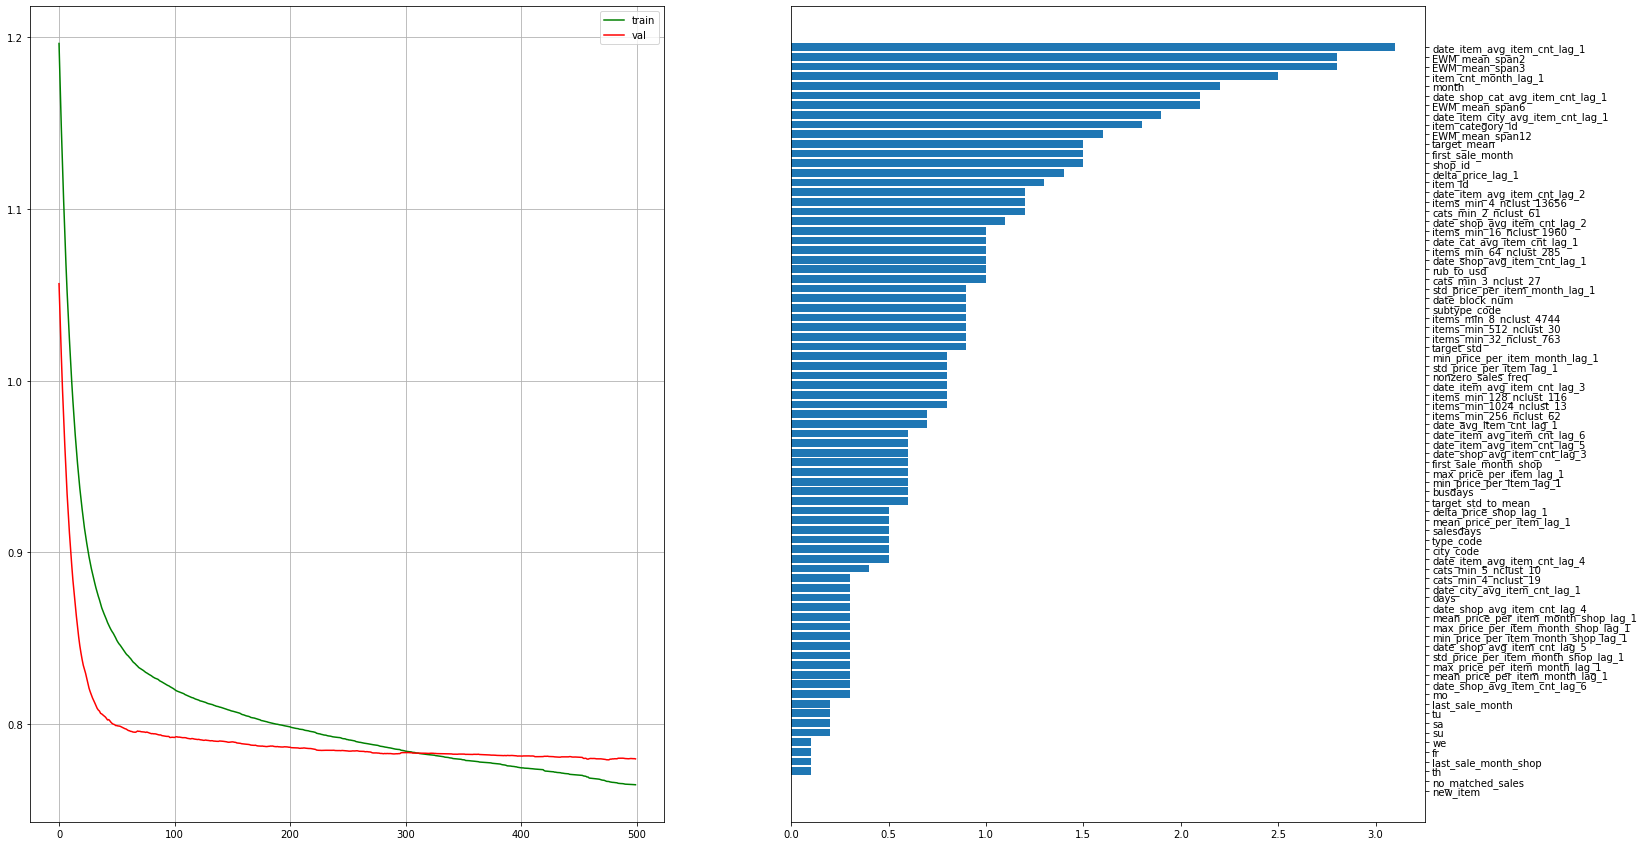

Wall time: 11min 42s


In [20]:
%%time
y_pred_train, y_pred_val, y_pred_test = LGBM(X, 'DL_mean_enc 500_None_10_0.05_TargetStat features', num_boost_round = 500, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05, retrain = False, plot = True)

In [82]:
%%time
y_pred_train, y_pred_val, y_pred_test = LGBM(X, 'DL mean enc features 500_None_10_0.05_retrain for train and val', num_boost_round = 500, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05, retrain = True, plot = False)

[500]	train's rmse: 0.76468	val's rmse: 0.783303
LGBM: RMSE train: 0.7644085166862907  RMSE val: 0.7829011541937101
[500]	trainval's rmse: 0.762138
LGBM: RMSE train and val: 0.7618747025905452
Wall time: 20min 5s


LGBM: RMSE train: 0.7644085166862907  RMSE val: 0.7829011541937101


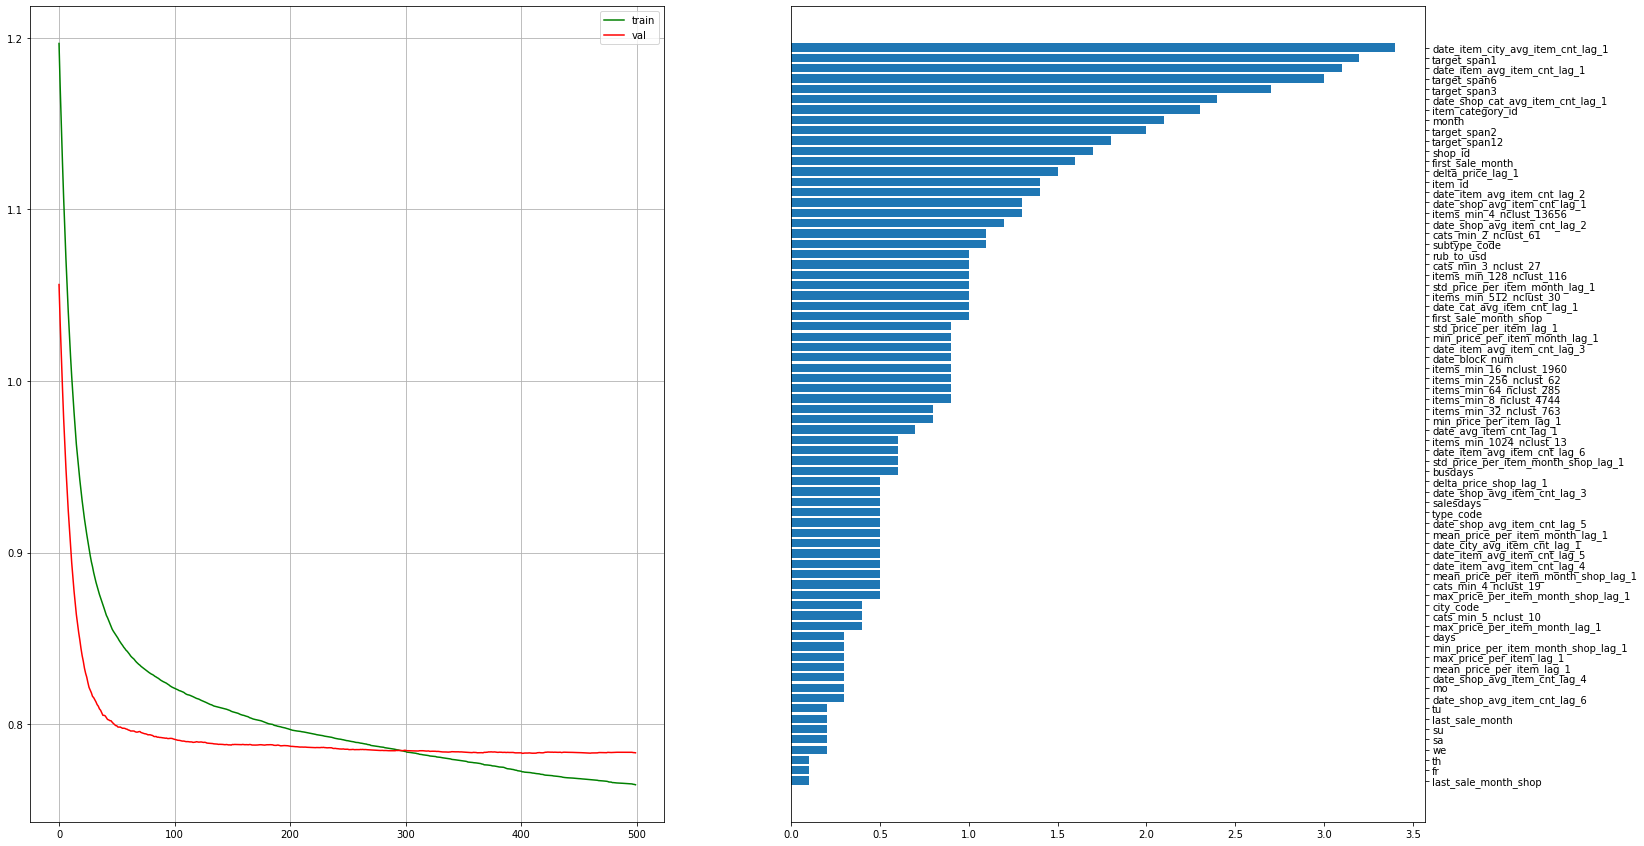

Wall time: 10min 4s


In [57]:
%%time
y_pred_train, y_pred_val, y_pred_test = LGBM(X, 'DL mean enc features 500_None_10_0.05', num_boost_round = 500, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05)

LGBM: RMSE train: 0.7636067643536821  RMSE val: 0.7849508093333135


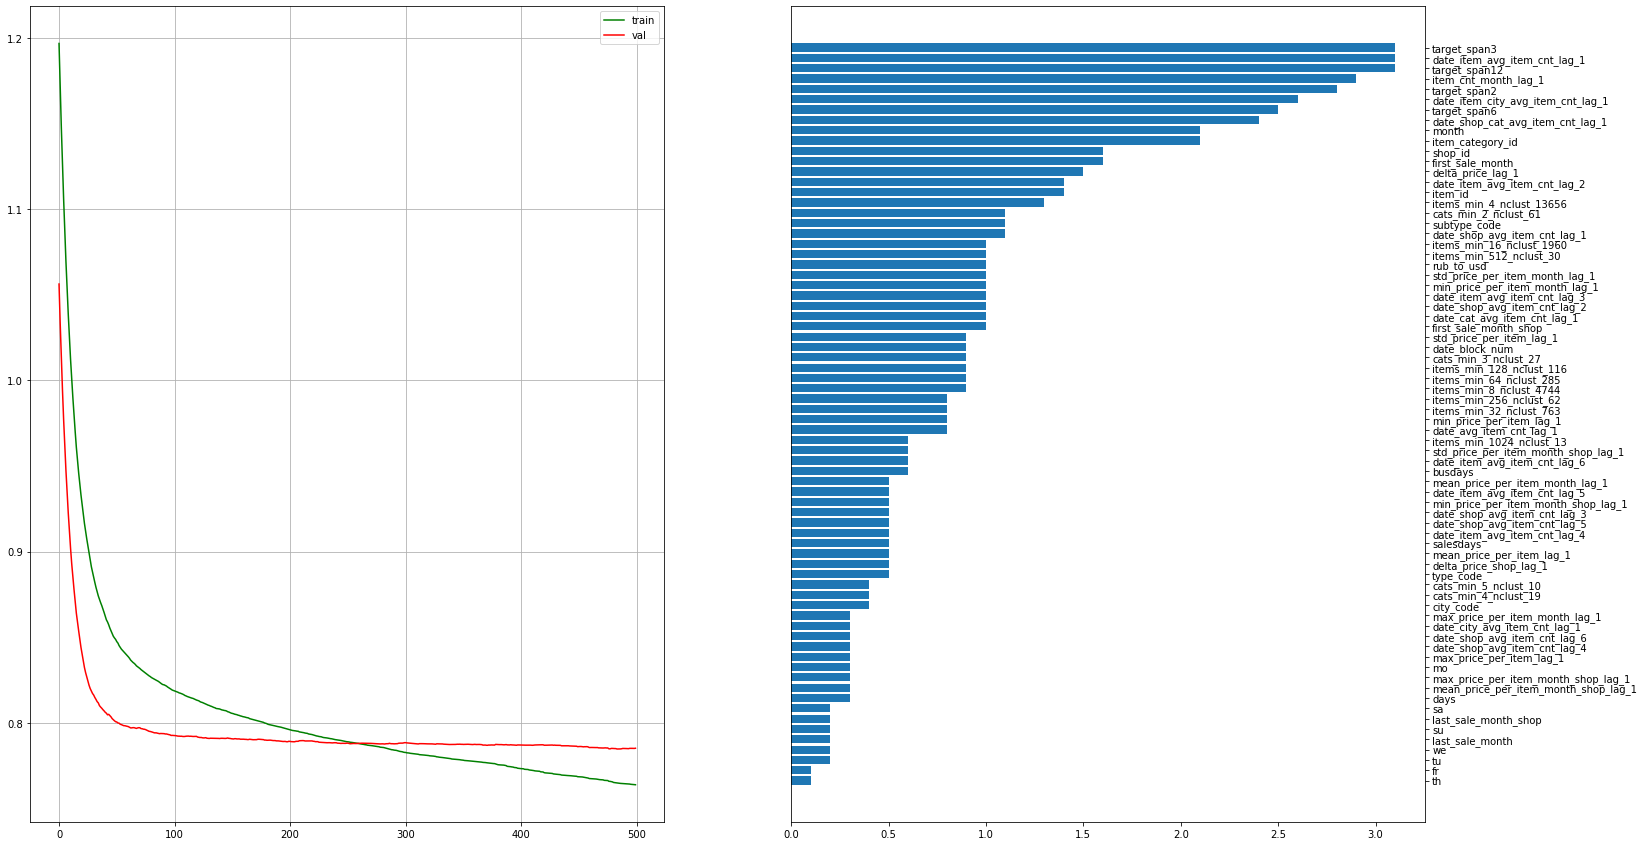

Wall time: 9min 55s


In [44]:
%%time
y_pred_train, y_pred_val, y_pred_test = LGBM(X, 'DL mean enc features 500_None_10_0.05', num_boost_round = 500, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05)

LGBM: RMSE train: 0.7644085166862907  RMSE val: 0.7829011541937101


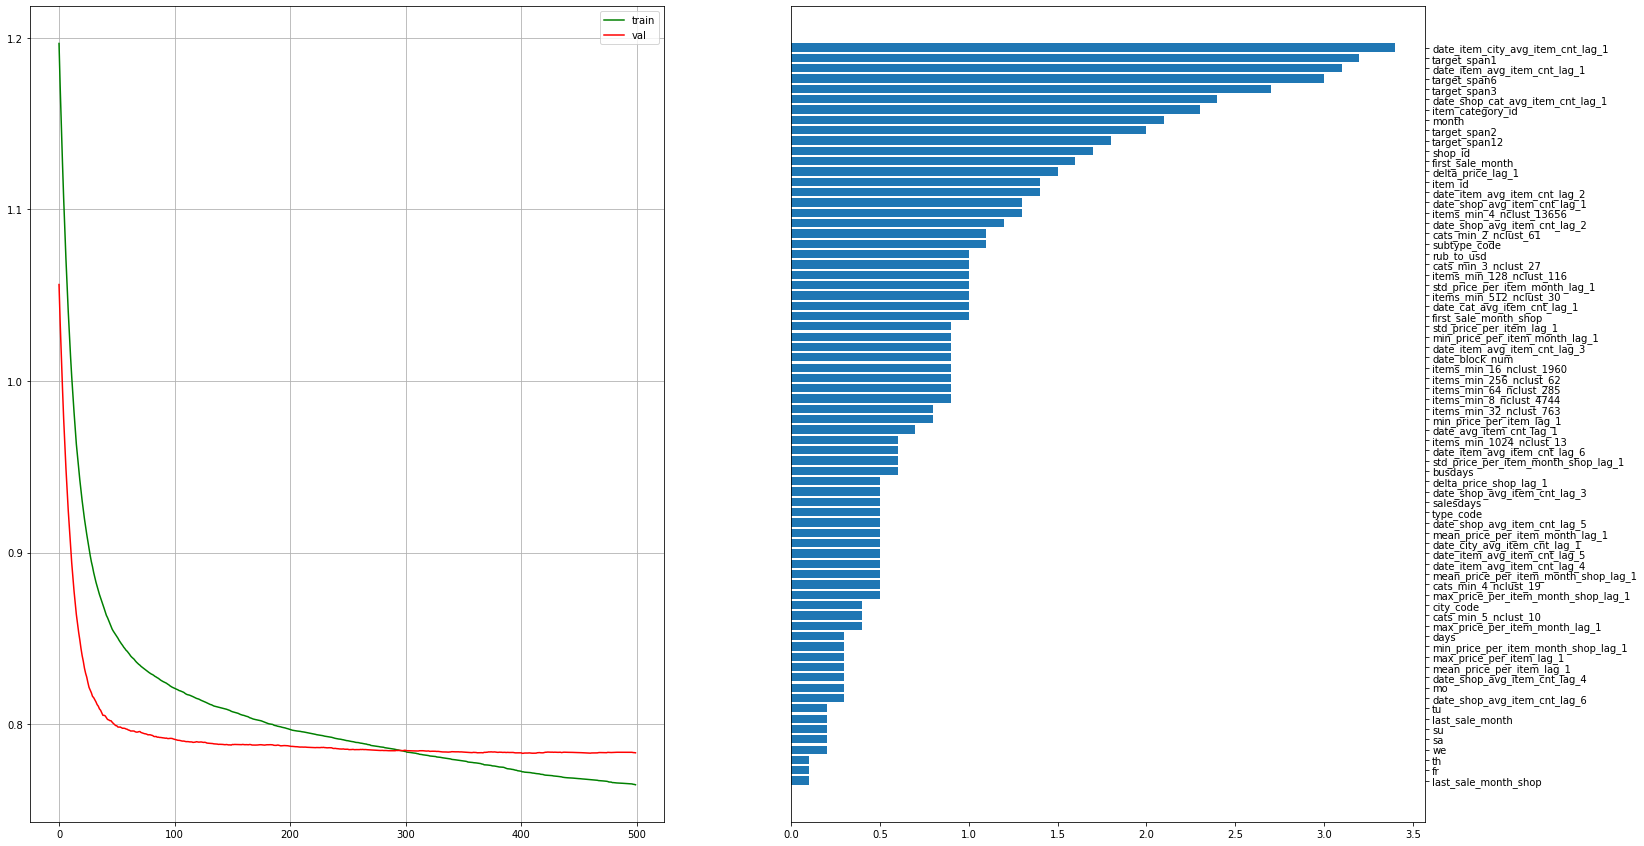

Wall time: 10min 43s


In [56]:
%%time
y_pred_train, y_pred_val, y_pred_test = LGBM(X, 'DL mean enc features 500_None_10_0.05', num_boost_round = 500, early_stopping_rounds = None, lambda_l2 = 10, learning_rate = 0.05)

[1000]	train's rmse: 0.698171	val's rmse: 0.781987
LGBM: RMSE train: 0.6972189800323111  RMSE val: 0.7801127941827182


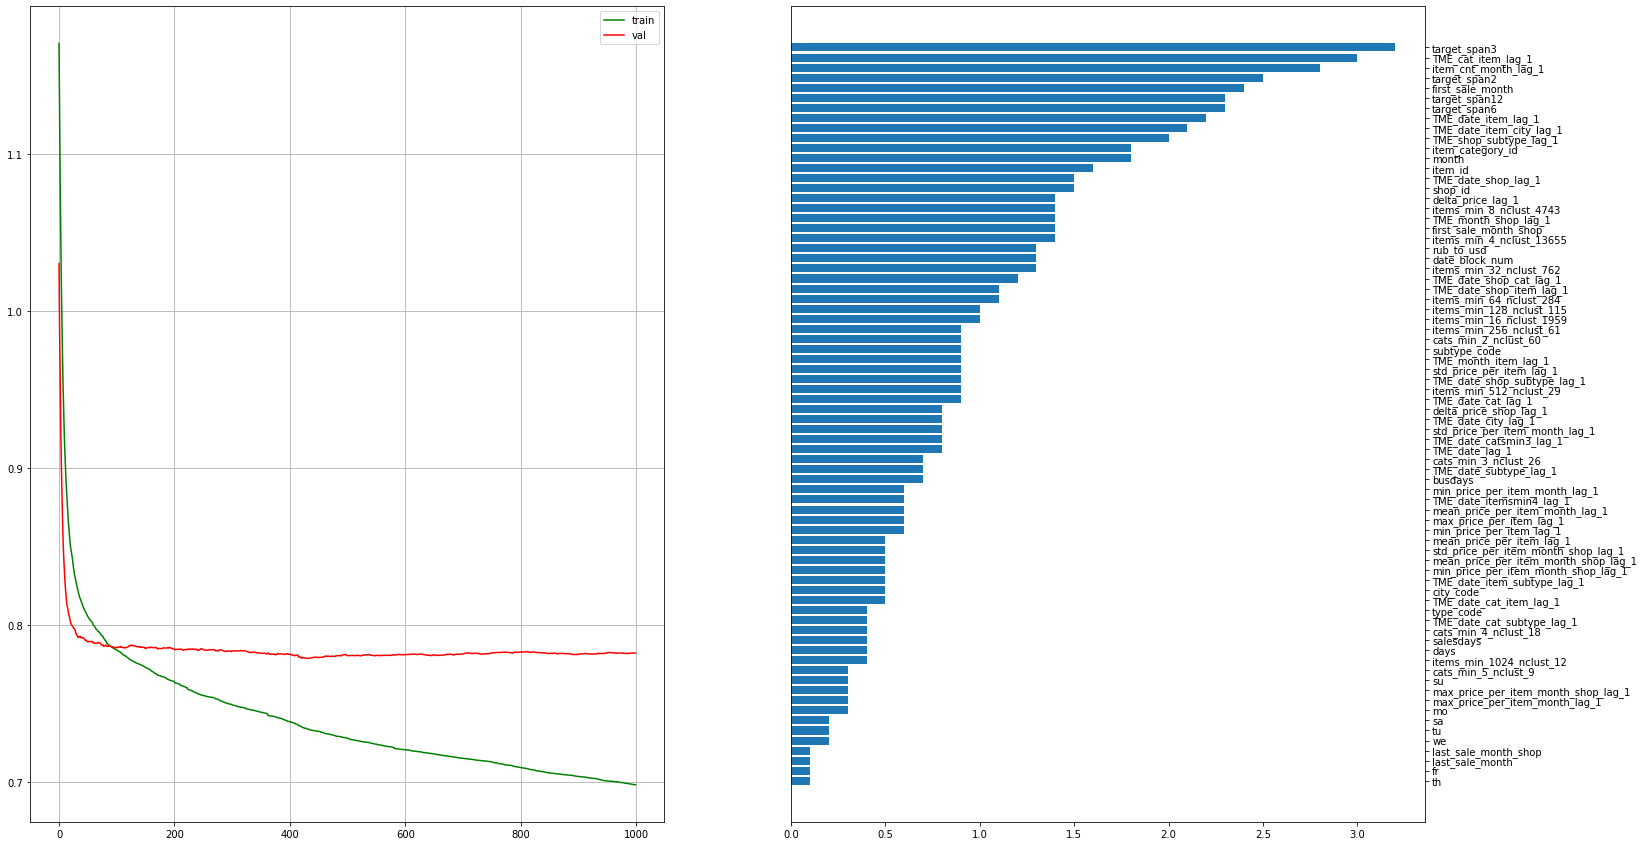

Wall time: 18min 39s


In [13]:
%%time
y_pred_train, y_pred_val, y_pred_test = LGBM(X, 'base_10000_1000_10_0.01', num_boost_round = 10000, early_stopping_rounds = 1000, lambda_l2 = 10, learning_rate = 0.01)

Training until validation scores don't improve for 2000 rounds
[1000]	train's rmse: 0.781856	val's rmse: 0.78581
[2000]	train's rmse: 0.759591	val's rmse: 0.780819
Did not meet early stopping. Best iteration is:
[2000]	train's rmse: 0.759591	val's rmse: 0.780819
LGBM: RMSE train: 0.7594066282461441  RMSE val: 0.7807072201686931


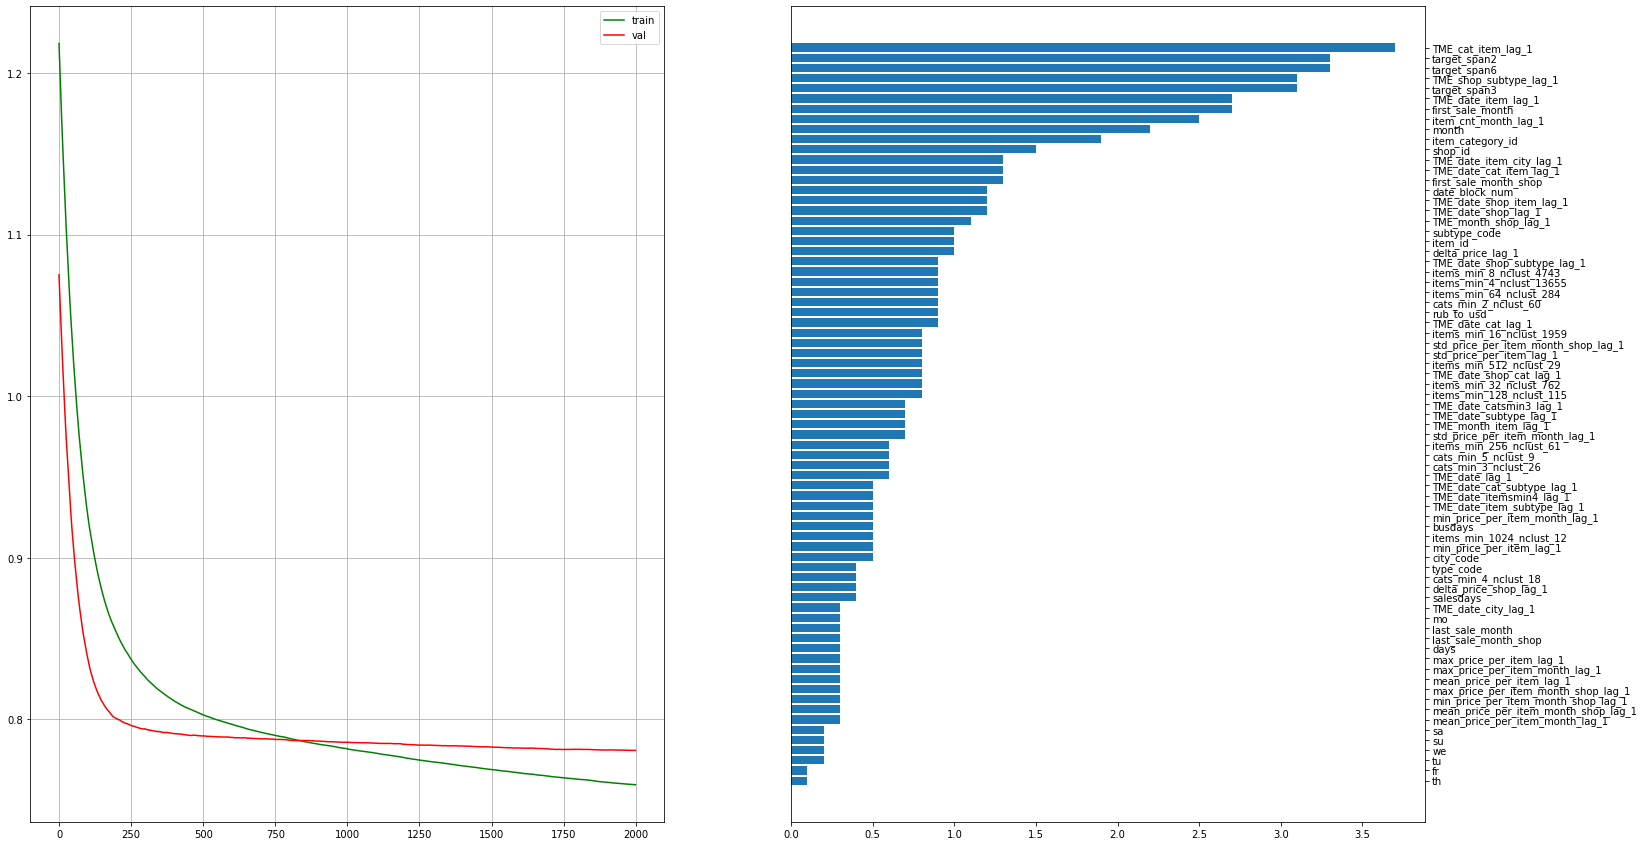

Wall time: 36min 6s


In [162]:
%%time
y_pred_train, y_pred_val, y_pred_test = LGBM(X, 'no_item_city_2000', num_boost_round = 2000, early_stopping_rounds = 2000, lambda_l2 = 10)

In [163]:
y_train = X[X.date_block_num < 33]['item_cnt_month']
y_val = X[X.date_block_num == 33]['item_cnt_month']

y_pred_train_round = y_pred_train.round()
y_pred_val_round = y_pred_val.round()
y_pred_test_round = y_pred_test.round()

In [164]:
display(np.unique(y_train, return_counts=True)[1],
        np.unique(y_pred_train_round, return_counts=True)[1],
        np.unique(y_val, return_counts=True)[1],
        np.unique(y_pred_val_round, return_counts=True)[1],
        np.unique(y_pred_test_round, return_counts=True)[1]
       )

array([6975311,  794603,  203068,   78725,   40448,   24143,   15620,
         10660,    7858,    5660,    4510,    3362,    2761,    2272,
          1821,    1527,    1311,    1175,     953,     862,    9369],
      dtype=int64)

array([7128886,  739511,  157944,   61373,   32540,   18996,   12017,
          8393,    6148,    4712,    3323,    2468,    1930,    1632,
          1191,     969,     779,     637,     654,     768,    1148],
      dtype=int64)

array([190984,  21155,   4953,   1833,    893,    511,    312,    199,
          136,    115,     74,     56,     52,     47,     40,     35,
           28,     19,     21,     12,    201], dtype=int64)

array([193912,  19686,   3977,   1486,    902,    542,    365,    253,
          148,    102,     78,     43,     30,     30,     26,     22,
           13,      8,     11,     31,     11], dtype=int64)

array([183989,  21095,   4432,   1631,    920,    651,    418,    348,
          218,    152,     95,     56,     43,     22,     29,     11,
           21,     11,     12,     43,      3], dtype=int64)

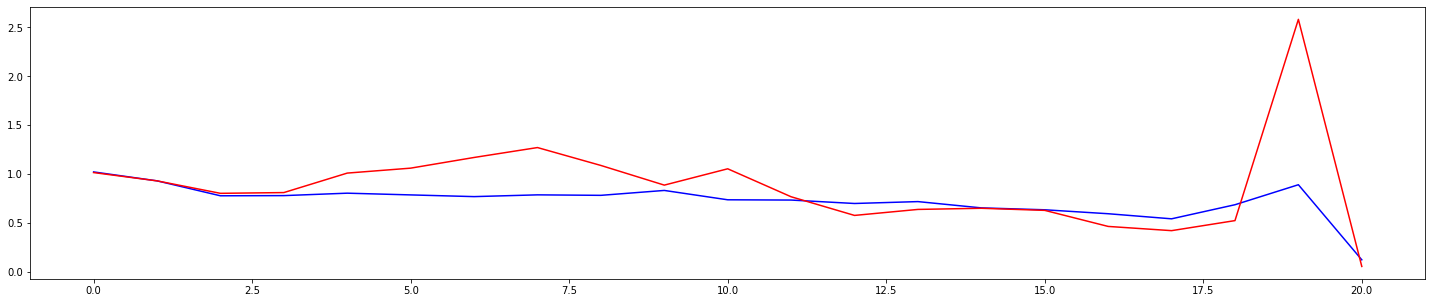

In [165]:
plt.plot(np.unique(y_pred_train_round, return_counts=True)[1]/np.unique(y_train, return_counts=True)[1], 'b')
plt.plot(np.unique(y_pred_val_round, return_counts=True)[1]/np.unique(y_val, return_counts=True)[1], 'r')
plt.show()

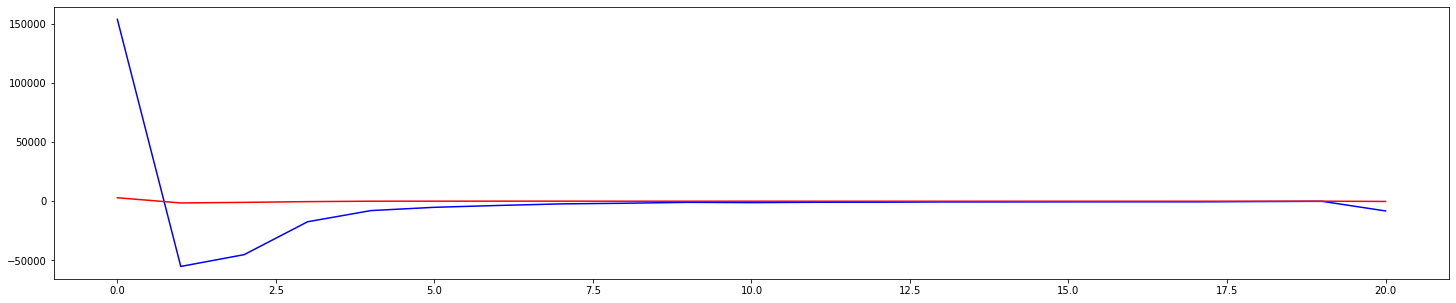

In [166]:
plt.plot(np.unique(y_pred_train_round, return_counts=True)[1] - np.unique(y_train, return_counts=True)[1], 'b')
plt.plot(np.unique(y_pred_val_round, return_counts=True)[1] -  np.unique(y_val, return_counts=True)[1], 'r')

Training until validation scores don't improve for 2000 rounds
[1000]	train's rmse: 0.783399	val's rmse: 0.7862
[2000]	train's rmse: 0.761769	val's rmse: 0.780316
Did not meet early stopping. Best iteration is:
[2000]	train's rmse: 0.761769	val's rmse: 0.780316
LGBM: RMSE train: 0.7615974380383614  RMSE val: 0.7801955656680136


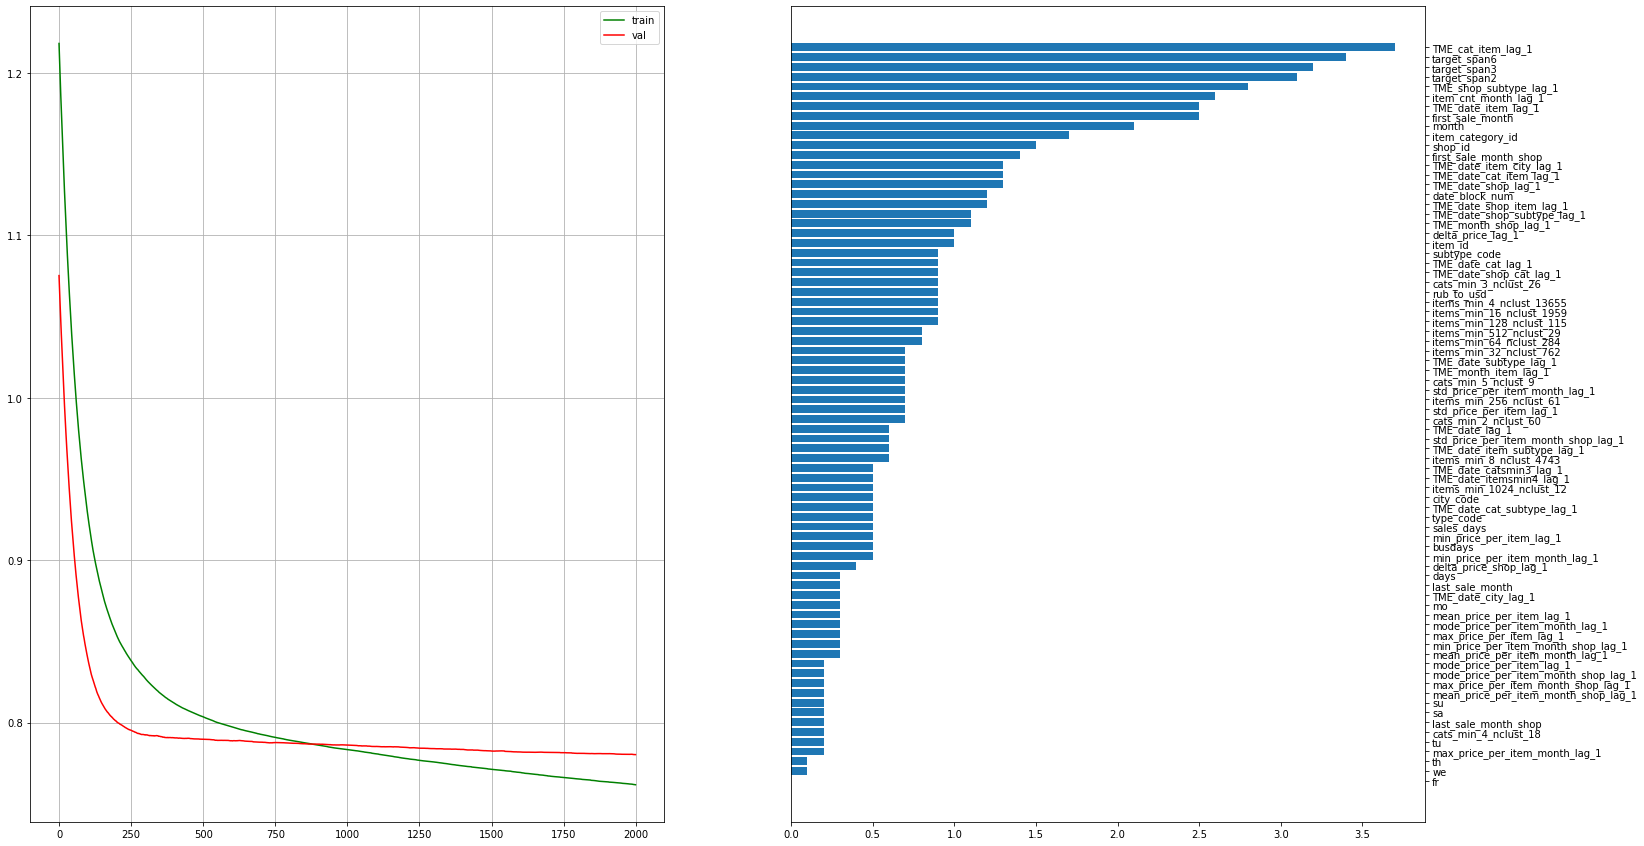

Wall time: 52min 14s


In [194]:
%%time
LGBM(X, 'no_item-city', num_boost_round = 2000, early_stopping_rounds = 2000, lambda_l2 = 10)

Training until validation scores don't improve for 2000 rounds
[1000]	train's rmse: 0.792222	val's rmse: 0.773422
[2000]	train's rmse: 0.772644	val's rmse: 0.768683
[3000]	train's rmse: 0.760534	val's rmse: 0.76645
[4000]	train's rmse: 0.750657	val's rmse: 0.764727
[5000]	train's rmse: 0.743226	val's rmse: 0.763383
[6000]	train's rmse: 0.736181	val's rmse: 0.7623
Did not meet early stopping. Best iteration is:
[6500]	train's rmse: 0.733232	val's rmse: 0.761769
LGBM: RMSE train: 0.7328850197946558  RMSE val: 0.761419789890899


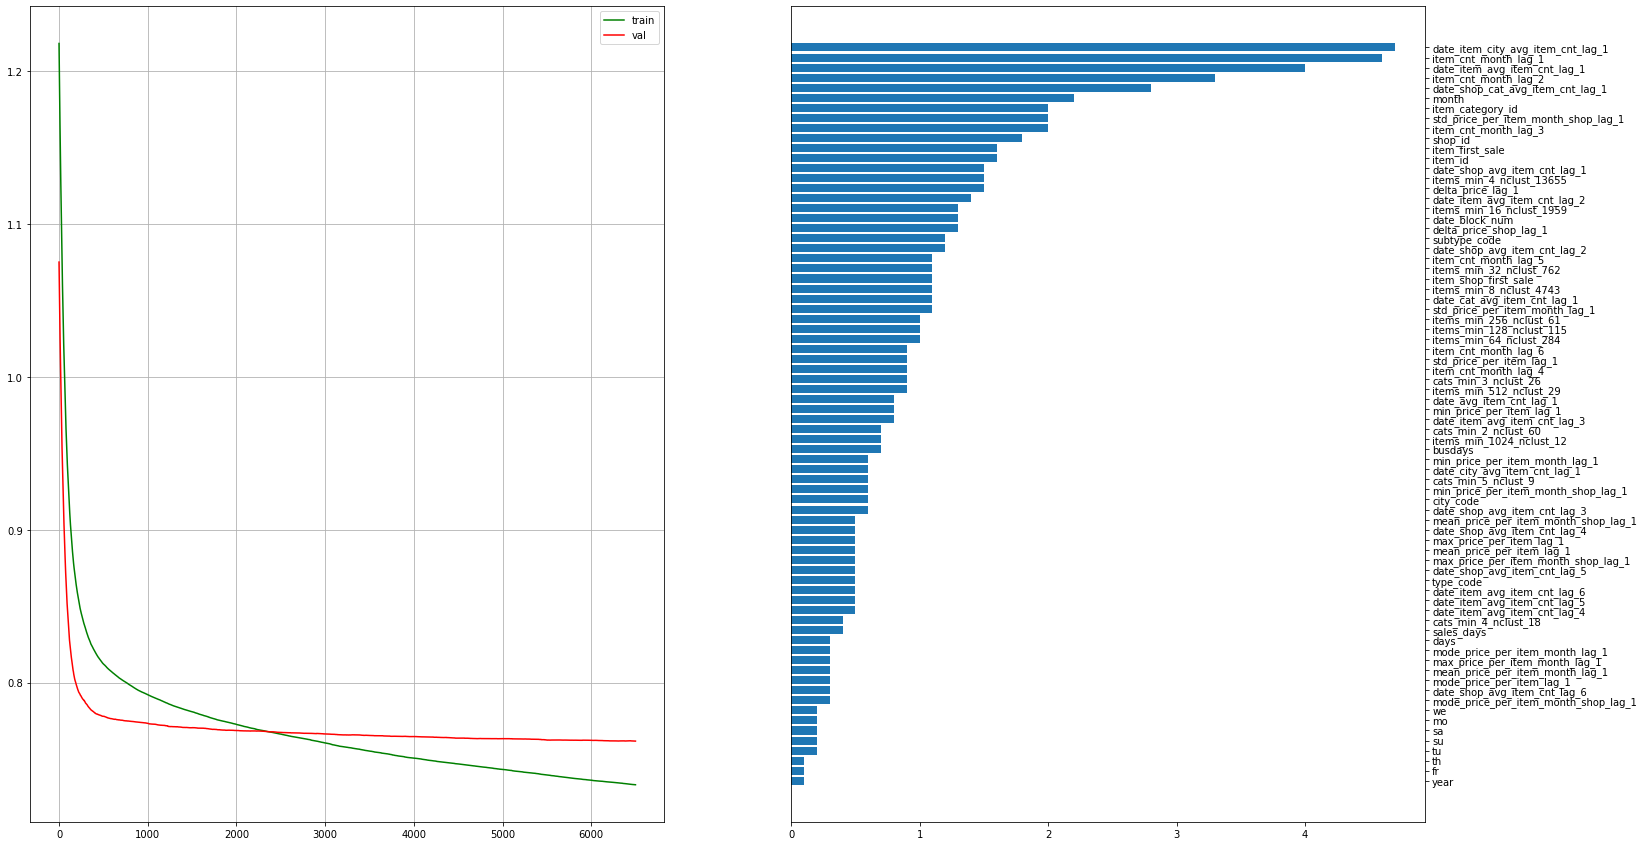

Wall time: 2h 17min 39s


In [69]:
%%time
LGBM(X, 'price aggregates lags', num_boost_round = 6500, early_stopping_rounds = 2000, lambda_l2 = 10)

Training until validation scores don't improve for 2000 rounds
[1000]	train's rmse: 0.794611	val's rmse: 0.772042
[2000]	train's rmse: 0.771568	val's rmse: 0.764906
Did not meet early stopping. Best iteration is:
[2000]	train's rmse: 0.771568	val's rmse: 0.764906
LGBM: RMSE train: 0.7714333417407537  RMSE val: 0.7647347176569707


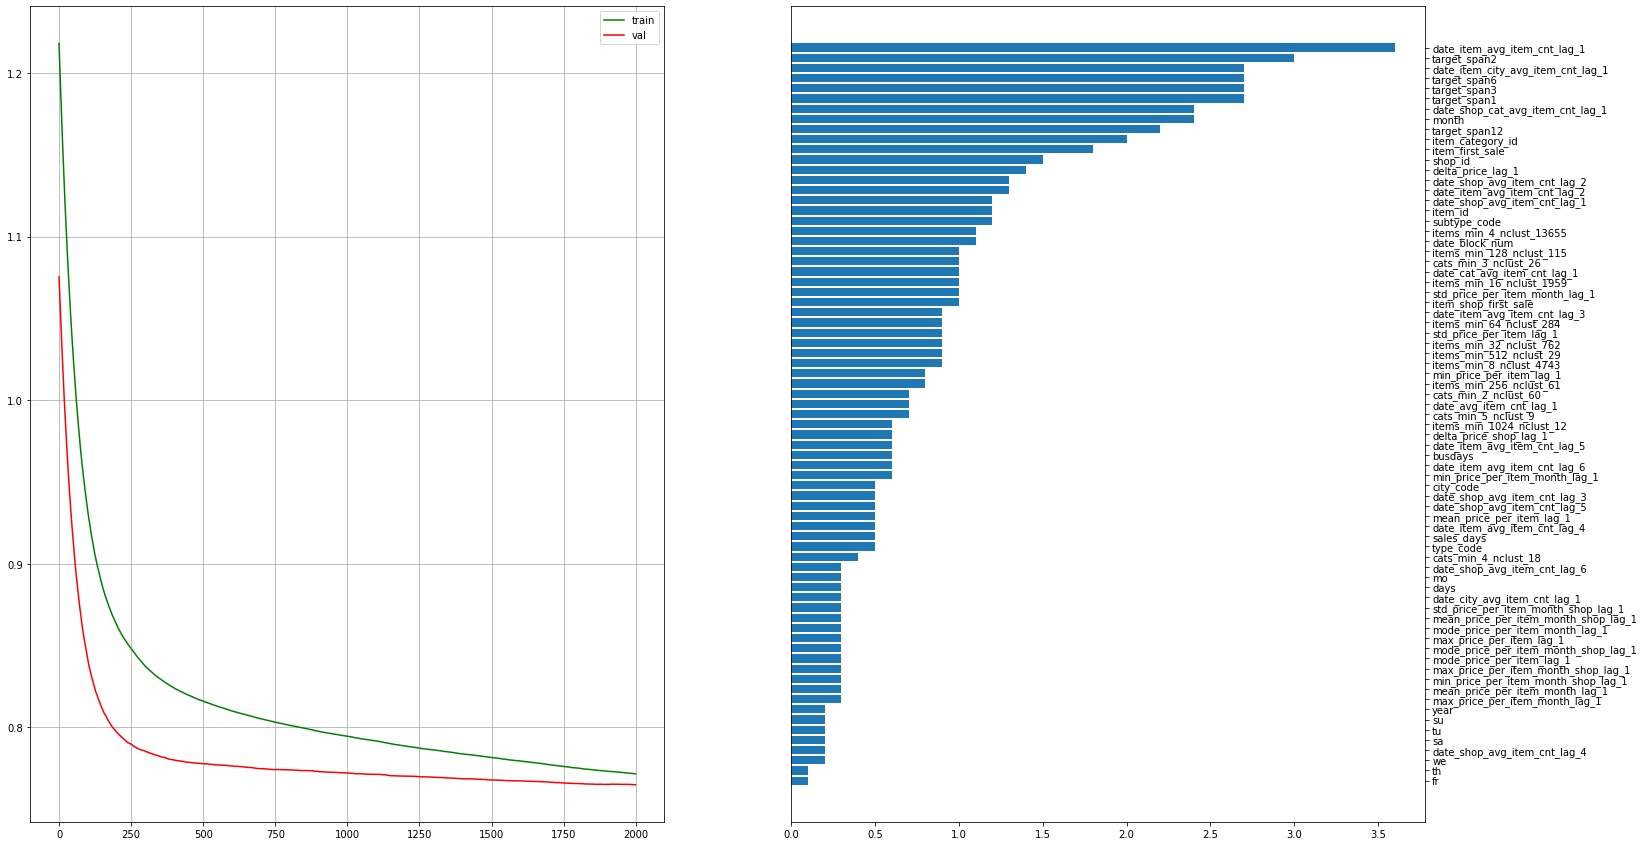

Wall time: 40min 4s


In [28]:
%%time
LGBM(X, 'repeat', num_boost_round = 2000, early_stopping_rounds = 2000, lambda_l2 = 10)

Training until validation scores don't improve for 2000 rounds
[1000]	train's rmse: 0.7983	val's rmse: 0.780694
[2000]	train's rmse: 0.776893	val's rmse: 0.775787
Did not meet early stopping. Best iteration is:
[2000]	train's rmse: 0.776893	val's rmse: 0.775787
LGBM: RMSE train: 0.7767486806369177  RMSE val: 0.7756266301802761


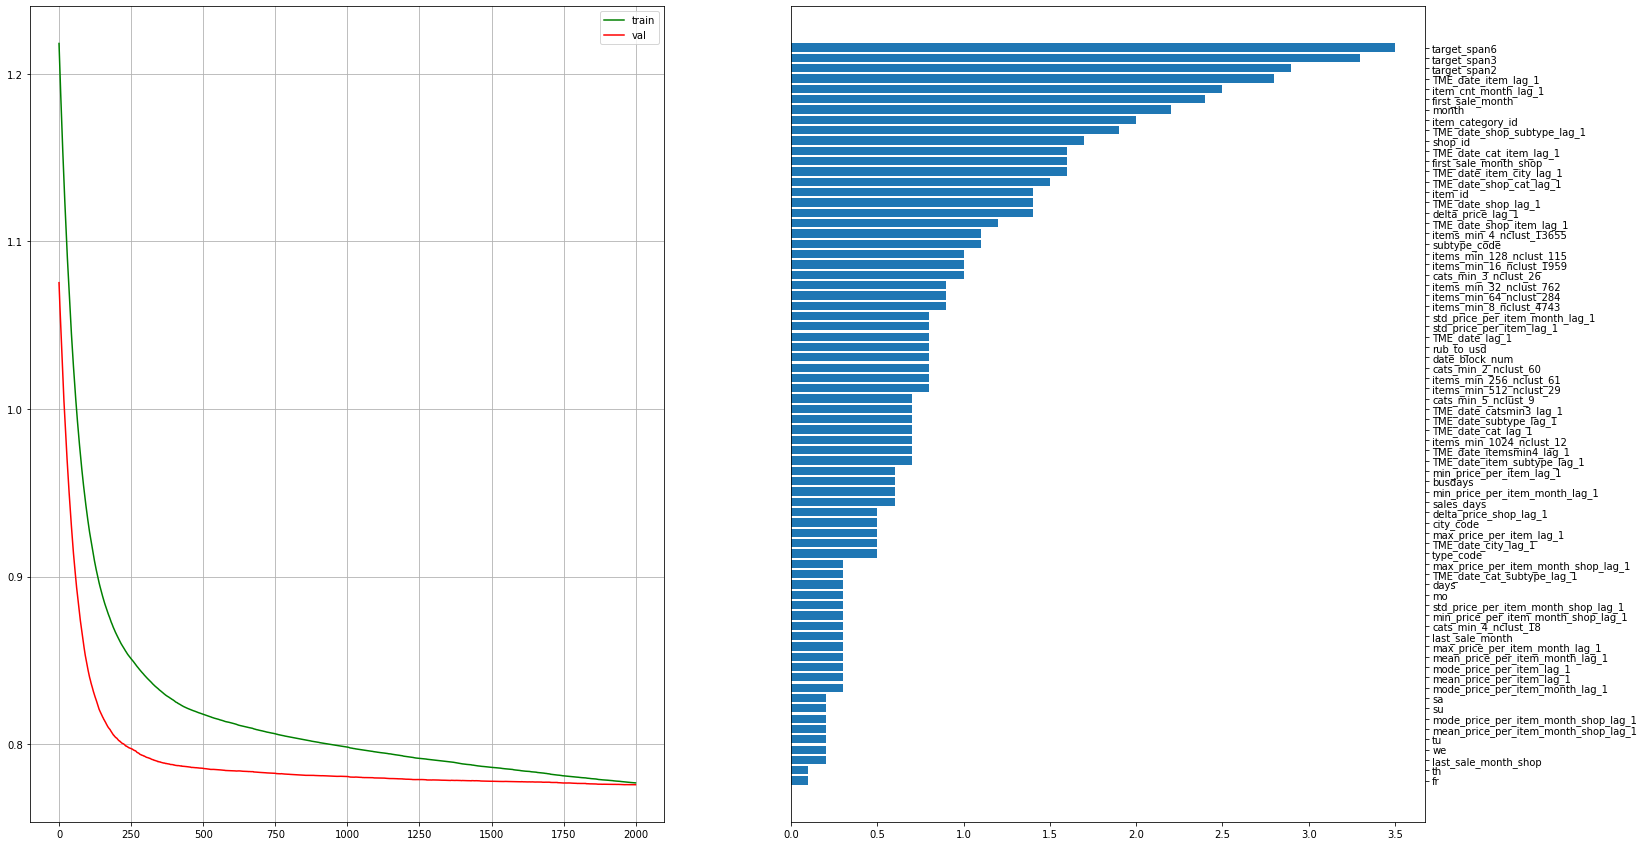

Wall time: 49min 35s


In [151]:
%%time
LGBM(X, 'new_mean_encodings', num_boost_round = 2000, early_stopping_rounds = 2000, lambda_l2 = 10)

Training until validation scores don't improve for 2000 rounds
[1000]	train's rmse: 0.768603	val's rmse: 0.776097
[2000]	train's rmse: 0.74539	val's rmse: 0.767972
Did not meet early stopping. Best iteration is:
[2000]	train's rmse: 0.74539	val's rmse: 0.767972
LGBM: RMSE train: 0.745181797988984  RMSE val: 0.7678283890145844


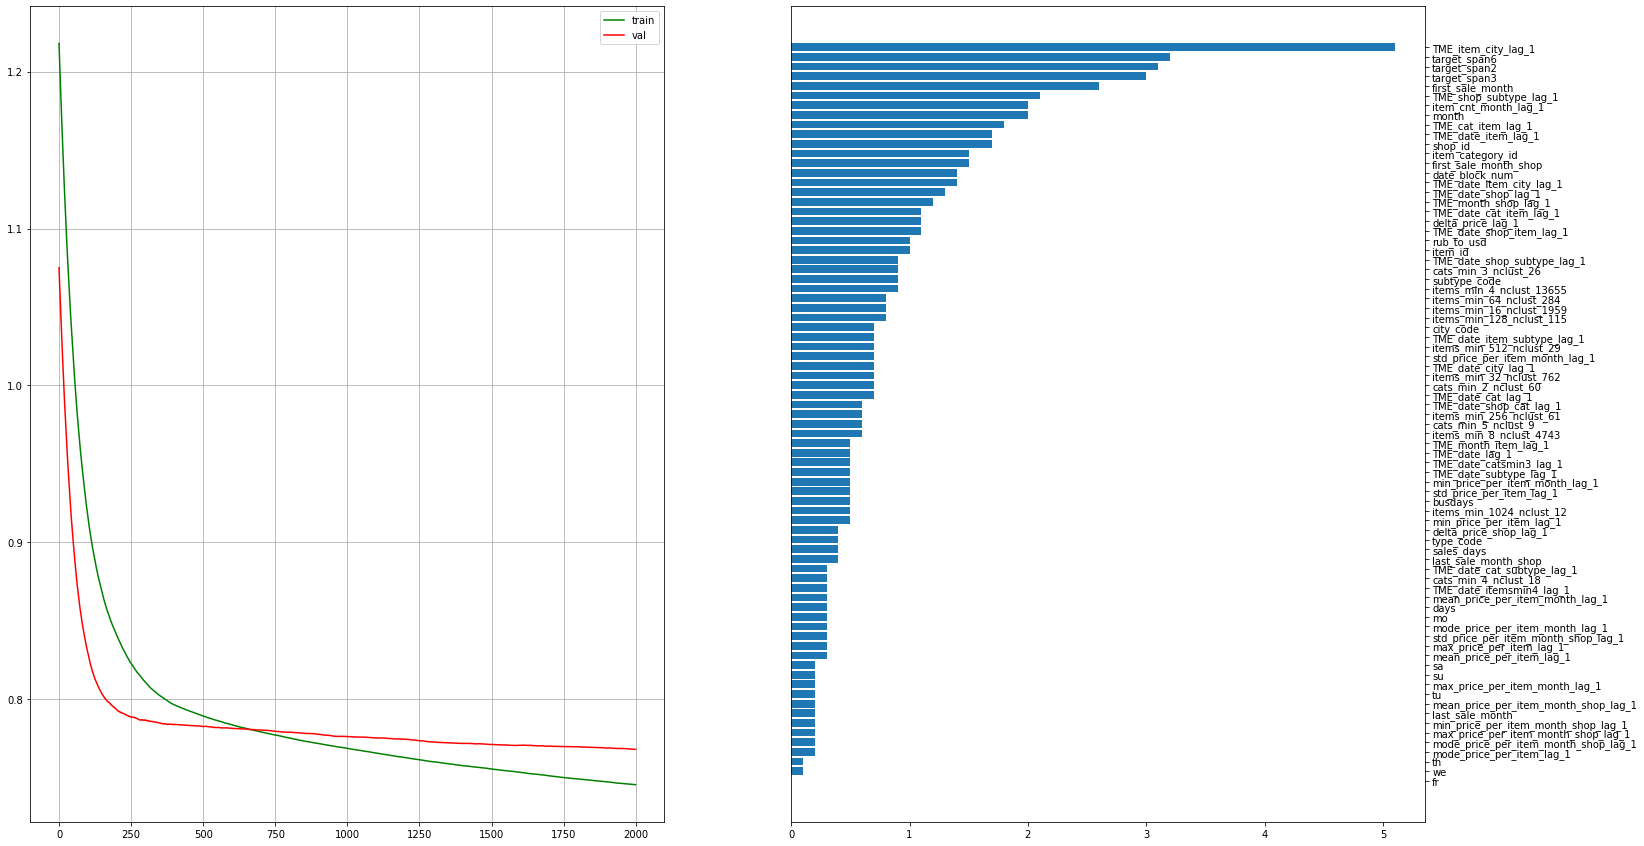

Wall time: 51min 53s


In [186]:
%%time
LGBM(X, 'more_new_mean_encodings', num_boost_round = 2000, early_stopping_rounds = 2000, lambda_l2 = 10)